---
---

# <center><font color=darkcyan> Approximate Bayesian Computation <br> for <br> Parameter Identification in Neuroscientific Models </font></center>

### <center><font color='black'>Nicolai Haug</font></center> 

### <center><font color='black'>Supervisors: Gaute Einevoll, Joakim Sundnes and Alexander Stasik</font></center> 
    
---
---

## <font color=darkcyan> Introduction </font>

#### <font color=darkred> Motivation </font>

* The development of mechanistic neuronal models drive advances in computational neuroscience.   
  
  
* Candidate models are validated by comparing with experiments.


* A central challenge is to identify the parametrization of the model which gives the best fit to experimental data.


* The <font color=darkred>Bayesian paradigm</font> of statistical inference provides a robust approach to identify parameters consistent with data.


* <font color=darkred>Problem:</font> Most mechanistic models have intractable likelihoods.
    * Without the likelihood function, traditional methods in the toolkit of statistical inference are inaccessible.


* <font color=darkred>Possible solution:</font> **Approximate Bayesian Computation (ABC)** are a family of so-called **likelihood-free inference (LFI)** algorithms. 
    * ABC does not require explicit numerical evaluation of likelihoods.
    * Only a simulator of the mechanistic model able to generate output on the same form as the observed data.
    
    
* <font color=darkred> Objective of master project:</font> Study whether ABC can be applied to identify parameters in neuroscientific models. 
* In particular:
    * The potassium and sodium conductance parameters, <font color=darkred>$\bar{g}_\mathrm{K}$</font> and <font color=darkred>$\bar{g}_\mathrm{Na}$</font>, in the **Hodgkin-Huxley model** for initiation and propagation of action potentials. 
    * The synaptic weight parameters, <font color=darkred>$\eta$</font>, <font color=darkred>$g$</font> and <font color=darkred>$J$</font>, in the **Brunel network model** for activity dynamics in local cortical networks. 

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-exclamation-circle" aria-hidden="true"></i>&nbsp; Configure Notebook </b><br>
<div>
</div>
</div>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 

import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from matplotlib import gridspec
from tqdm import tqdm_notebook as tqdm

# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rc('text', usetex=True)

sns.set(context="paper", style='whitegrid', rc={"axes.facecolor": "0.98"})

## <font color=darkcyan> The Bayesian Paradigm </font>

#### <font color=darkred> General Notation </font> 

| Symbol                  | Description          |
| ----------------------- |:---------------------|
| $\theta$                | model parameters     |
| $y$                     | data                 |
| $\pi(\cdot \mid \cdot)$ | posterior            |
| $p(\cdot \mid \cdot)$   | likelihood           |
| $\pi(\cdot)$            | prior                |

#### <font color=darkred> Bayesian Inference </font>

* In terms of parameter inference, the <font color=darkred>Bayesian</font> approach differs from the <font color=darkred>frequentist</font>. 
    * <font color=darkred>Bayesian:</font> unknown $\theta$ are treated as random variables.
    * <font color=darkred>Frequentist:</font> unknown $\theta$ are treated as fixed quantities.
    * <font color=darkred>Bayesian:</font> inference is performed by conditioning on fixed $y$.
    * <font color=darkred>Frequentist:</font> $y$ is a repeatable random sample.
    
**Prior**

* In the Bayesian paradigm, all available information about $\theta$ is incorporated in a **prior probability distribution**.
* We usually have a prior pdf $\pi(\theta)$, since there will typically be a continuum of possible values.

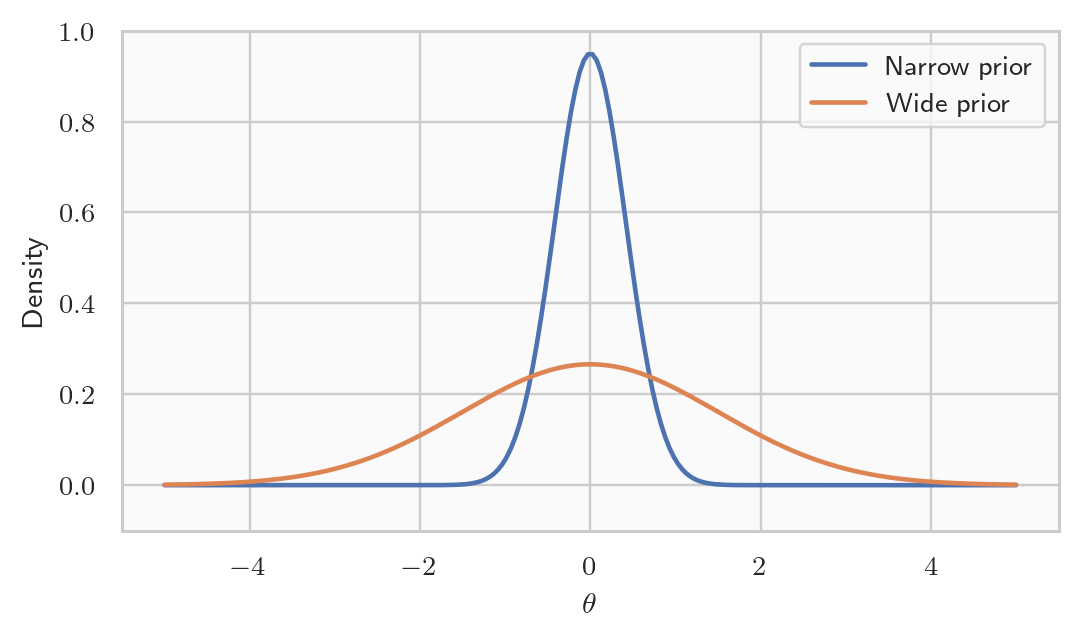

In [2]:
fig = plt.figure(figsize=(5, 3), tight_layout=True, dpi=110)
x = np.linspace(-5, 5, 200)
y_narrow = stats.norm(0, 0.42).pdf(x)
y_wide = stats.norm(0, 1.5).pdf(x)

plt.plot(x, y_narrow, lw=1.5, label='Narrow prior')
plt.plot(x, y_wide, lw=1.5, label='Wide prior')
plt.ylabel(r"Density")
plt.xlabel(r"$\theta$")
plt.ylim(-0.1, 1)
plt.legend()
plt.show()

* In the case of substantial prior knowledge about $\theta$, the prior pdf is narrow and concentrated about some central value. 
* Lack of information yield a wider and relatively flat prior pdf.


* $\pi(\theta)$ is usually chosen among a set of well-known and tractable distributions.
    * Makes evaluation of prior probabilities and random generation of $\theta$ straightforward.
    
    
**Bayes' Theorem** 

* Our prior state of knowledge is modified by data $y$ through the **likelihood function** $p(y \mid \theta)$.
    * $p(y \mid \theta)$ is regarded as a function of $\theta$ for fixed $y$
 
 
* <font color=darkred>Bayes' theorem</font> is used to produce the **posterior probability distribution** $\pi (\theta \mid y)$.
    * The posterior represents our state of knowledge about $\theta$ in the light of $y$.


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-pencil" aria-hidden="true"></i>&nbsp; Bayes' Theorem</b><br>
<div>

\begin{equation}
    \pi (\theta \mid y) = \frac{p(y \mid \theta) \pi (\theta)}{p(y)}
\end{equation}

</div>
</div>


* $p(y)$ is the same for all possible $\theta$, as it does not depend on $\theta$.
* With fixed $y$, this factor can thus be omitted in parameter inference since it only constitutes a normalizing constant. 


* Omitting the factor $p(y)$ yields the unnormalized posterior distribution: 

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-pencil" aria-hidden="true"></i>&nbsp; Unnormalized Posterior Distribution</b><br>
<div>

\begin{equation}
    \pi (\theta \mid y) \propto p (y \mid \theta) \pi (\theta)
\end{equation}

</div>
</div>


#### <font color=darkred> Why Bayesian?  </font>

* Local point-estimates:
    1. are potentially poor representations of the true parameter
    2. hide the fact that many similar parameters would be capable of describing the data equally well 
    
    
* This should be reason enough to consider interval estimators, in particular, Bayesian methods from the outset.

## <font color=darkcyan> Likelihood-Free Inference </font>

* Many mechanistic models in neuroscience are defined implicitly through <font color=darkred>simulators</font>:
    * That is, a set of dynamical equations which can be run forward to generate data. 
    
    
* Likelihoods can be derived for purely statistical models, but are generally intractable or computationally infeasible for simulation-based models.


* <font color=darkred>Likelihood-free inference (LFI)</font> methods bypass the evaluation of the likelihood function.
    * These methods seek to directly estimate either the posterior or the likelihood. 
    * They only require the ability to generate data from the simulator to analyze the model in a fully Bayesian context.
    

* In general, <font color=darkred>likelihood-free</font> methods are less efficient than <font color=darkred>likelihood-based</font> methods.
    * The former can require lots of simulation to produce accurate results.
    
    
#### <font color=darkred> The ABC of Approximate Bayesian Computation </font>

* <font color=darkred>Approximate Bayesian Computation (ABC)</font> constitutes a class of computational methods rooted in Bayesian statistics. 
    * They can be used to evaluate posterior distributions of model parameters without having to explicitly evaluate likelihoods. 
    
**Algorithm** 

* Given data $y$, a model $\mathcal{M}$ with parameters $\theta$ having a prior $\pi(\theta)$, we can simulate posterior samples from:

\begin{equation}
    \pi (\theta \mid y) \propto p(y \mid \theta) \pi(\theta),
\end{equation}

via:

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-calculator" aria-hidden="true"></i>&nbsp; Algorithm A</b><br>
<div>
    
* __A1:__ Generate $\theta \sim \pi(\theta)$
* __A2:__ Accept $\theta$ with probability proportional to the likelihood $p(y \mid \theta)$

</div>
</div>

* <font color=darkred>Algorithm A</font> can be extended dramatically in its usefulness using the following, stochastically equivalent, version:

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-calculator" aria-hidden="true"></i>&nbsp; Algorithm B (Rubin, 1984)</b><br>
<div>
    
* __B1:__ Generate $\theta \sim \pi(\theta)$
* __B2:__ Simulate data $y'$ from model $\mathcal{M}(\theta)$
* __B3:__ Accept $\theta$ if $y' = y$

</div>
</div>

* While algorithms A and B are probabilistically identical, B is much more general in that one does not need to compute probabilities explicitly to make it work; only simulation is needed. 


* The drawback of B is clear. 
    * The chance of the outcome $y'=y$ is either vanishingly small or very time consuming to compute. 
    * The result is an ineffective algorithm. 
    
    
* This is where <font color=darkred>ABC</font> comes into play in the form of the following scheme:
    * We start with a distance metric $\rho$ to compare datasets and a tolerance $\epsilon \geq 0$.
    * Then:


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-calculator" aria-hidden="true"></i>&nbsp; Algorithm C (Pritchard et al., 1999)</b><br>
<div>
    
* __C1:__ Generate $\theta \sim \pi(\theta)$
* __C2:__ Simulate data $y'$ from model $\mathcal{M}(\theta)$ 
* __C3:__ Compute $\rho \equiv \rho (y', y)$, and accept $\theta$ as an appropriate draw from $\pi (\theta \mid y)$ if $\rho \leq \epsilon$

</div>
</div>


* <font color=darkred>Algorithm C</font> is called <font color=darkred>Rejection ABC</font>.


* Because of the curse of dimensionality, <font color=darkred>ABC</font> methods require a compression of the data into low-dimensional summary statistics $S(y)=s$.


* The acceptance criterion in C3 then becomes $\color{blue}{\rho(S(y'), S(y)) = \rho(s', s) \leq \epsilon}$ 


* The algorithm produces the approximate posterior $\color{blue}{\pi_\mathrm{ABC} \left( \theta \mid \rho (s', s) \leq \epsilon \right)}$


* If $\rho = 0 \implies y'=y$, then such an accepted $\theta$ is indeed a sample from the true posterior.


* A summary statistic that contains the same amount of information about model parameters as the whole dataset, is referred to as being a **sufficient statistic**. 


* If the statistics are sufficient for $\theta$, then when $\epsilon=0$, the accepted values of $\theta$ are still from the true posterior. 


* Sufficient statistics are hard to come by, but if powerful low-dimensional summary statistics are established, <font color=darkred>ABC</font> can still offer a reasonable performance. 

 

**Rejection ABC Scheme**

<img src="ABC_illustration.pdf" width="600" height="600" align="center"/>

## <font color=darkcyan> The Hodgkin-Huxley Model </font>

* From a biophysical point of view, action potentials are the result of currents that pass through ion channels in the cell membrane. 
* In an extensive series of experiments on the giant axon of the squid, Hodgkin and Huxley succeeded to measure these currents and to describe their dynamics in terms of differential equations.


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-pencil" aria-hidden="true"></i>&nbsp; Hodgkin-Huxley Model</b><br>
<div>

\begin{equation}
    C\frac{dV}{dt} = I - \color{red}{\bar{g}_\mathrm{K}} n^4 (V - E_\mathrm{K}) - \color{red}{\bar{g}_\mathrm{Na}} m^3 h(V - E_\mathrm{Na} ) - \bar{g}_\mathrm{L} (V - E_\mathrm{L})
\end{equation}

</div>
</div>


## <font color=darkcyan> Software </font> 

#### <font color=darkred> pyLFI </font>

* The Python toolbox `pyLFI` has been developed as a part of the master project. 
    * uses ABC with rejection and MCMC sampling for estimating posterior distributions of model parameters. 
  
  
* To perform Bayesian parameter identification with `pyLFI`, four types of input need to be specified:
    1. A mechanistic model. The model only needs to be specified through a simulator, that is that one can generate a simulation result $y'$ for any parameters $\theta$. 
    2. A summary statistics calculator. The ABC algorithms require the use of summary statistics $S(y)=s$ calculated from the raw data $y$. 
    3. Observed data $y$ of the same form as the results $y'$ produced by model simulations. 
    4. A prior distribution $\pi (\theta)$ describing the range of possible parameters.
    
    
* For each problem, the goal is to estimate the (approximate) posterior distribution $\color{blue}{\pi_\mathrm{ABC} \left( \theta \mid \rho (s', s) \leq \epsilon \right)}$. 


* Setting up the inference procedure requires three design choices:
    1. A distance metric.
    2. Value of hyperparameters. The number of hyperparameters depends on which ABC algorithm is being used. The central hyperparameter for all algorithms is the threshold $\epsilon$. For the MCMC algorithm, there are additional hyperparameters like proposal density scale, burn-in iterations etc.  
    3. A simulation budget, i.e. the number of samples to generate. Running the simulator is generally the most time consuming part of the procedure, and the ABC methods require lots of simulations to accurately produce the posterior. 

#### <font color=darkred> NeuroModels </font>
    
    
* The Python library `NeuroModels` has also been developed. 
    * The aim of `NeuroModels` is just to provide a framework for the simulator models used in the project.


#### <font color=darkred> Open-source </font>

* Both packages will be available via the Python Package Index (PyPI). 

## <font color=darkcyan> Inference Example </font>

### Task

**Infer parametrization of a Gaussian model**

In [3]:
import pylfi

### Simulator model

In [4]:
def gaussian_model(mu, sigma, n_samples=1000):
    sim = stats.norm(loc=mu, scale=sigma).rvs(size=n_samples)
    return sim

### Summary statistics calculator

In [5]:
def summary_calculator(data):
    sumstat = np.array([np.mean(data), np.std(data)])
    return sumstat

### Observed data

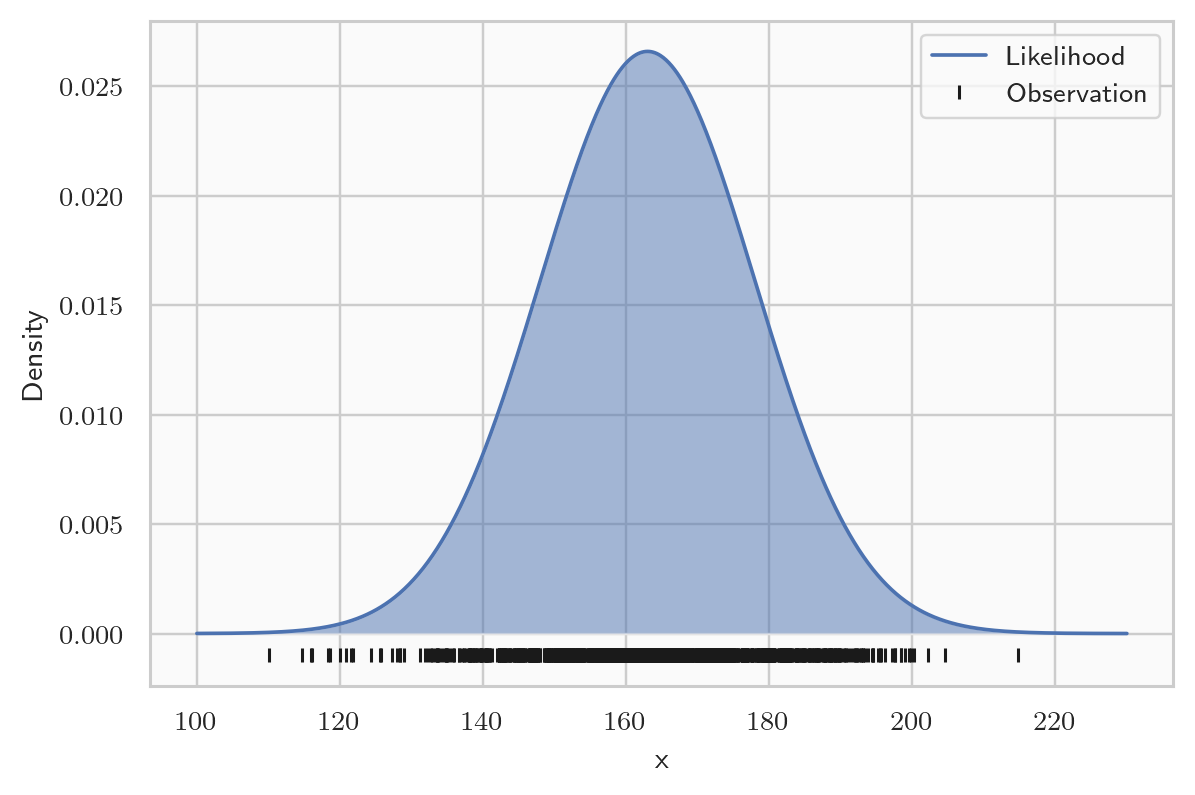

In [6]:
N = 1000
mu_true = 163
sigma_true = 15
true_parameter_values = [mu_true, sigma_true]

likelihood = stats.norm(loc=mu_true, scale=sigma_true)
obs_data = likelihood.rvs(size=N)

# plot observation and likelihood
x = np.linspace(100, 230, N)
lhood_pdf = likelihood.pdf(x)
fig, ax = plt.subplots(figsize=(6, 4), dpi=110)

ax.plot(x, 
        lhood_pdf, 
        label="Likelihood"
       )
ax.fill_between(x, 
                lhood_pdf, 
                alpha=0.5
               )
ax.plot(obs_data, 
        np.full_like(obs_data, -0.001), 
        '|k', 
        markeredgewidth=1, 
        label="Observation"
       )
ax.set(xlabel="x",
      ylabel="Density"
      )
ax.legend()
plt.show()

### Priors 

* Flat (uninformative) priors

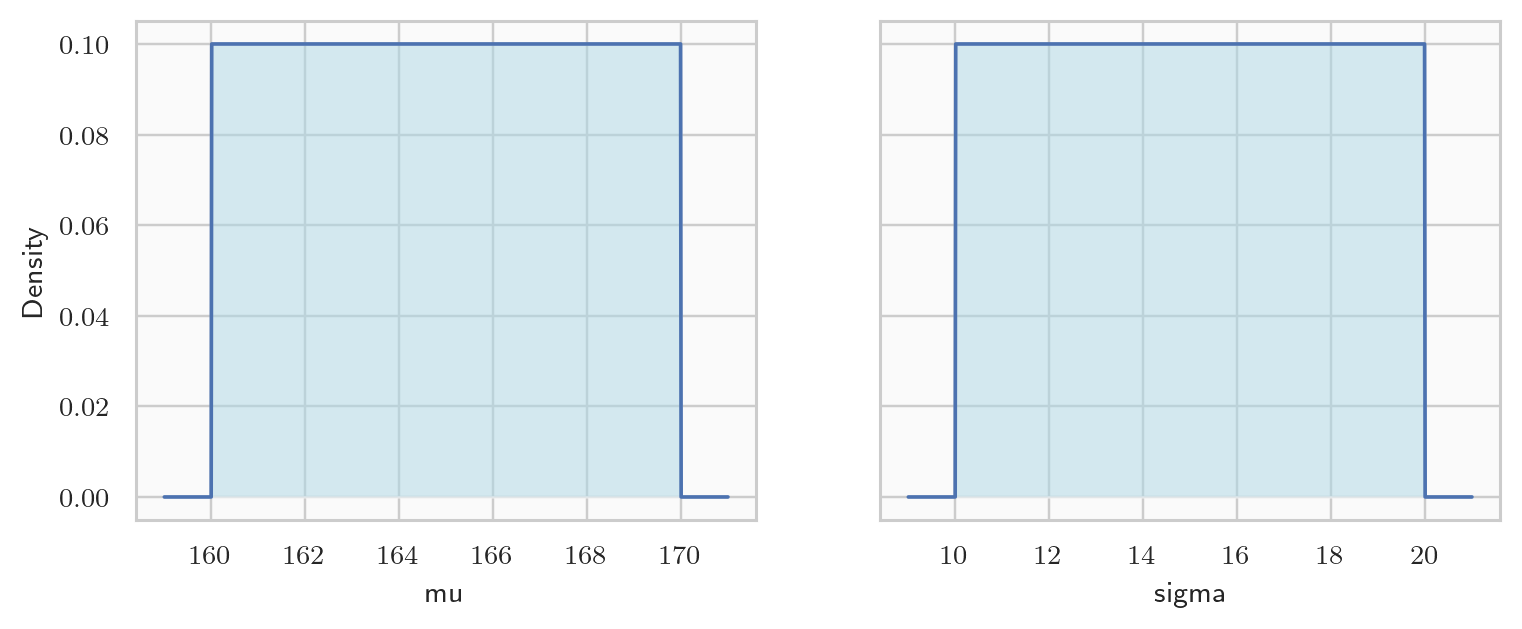

In [7]:
mu = pylfi.Prior('uniform', loc=160, scale=10, name='mu')
sigma = pylfi.Prior('uniform', loc=10, scale=10, name='sigma')
priors = [mu, sigma]

# Plot priors
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=110, sharey=True)

x = np.linspace(159, 171, 1000)
mu.plot_prior(x, ax=axes[0])

x = np.linspace(9, 21, 1000)
sigma.plot_prior(x, ax=axes[1])
axes[1].set_ylabel("")

plt.show()

### Rejection ABC Sampler

In [8]:
# initialize sampler
sampler = pylfi.RejABC(obs_data,
                       gaussian_model,
                       summary_calculator,
                       priors,
                       distance_metric='l2',
                       seed=42
                      )

# inference config
n_samples = 1000
epsilon = 1.0

# run inference
journal = sampler.sample(n_samples,
                         epsilon=epsilon,
                         n_jobs=-1,
                         log=False
                         )

#### Plot trace

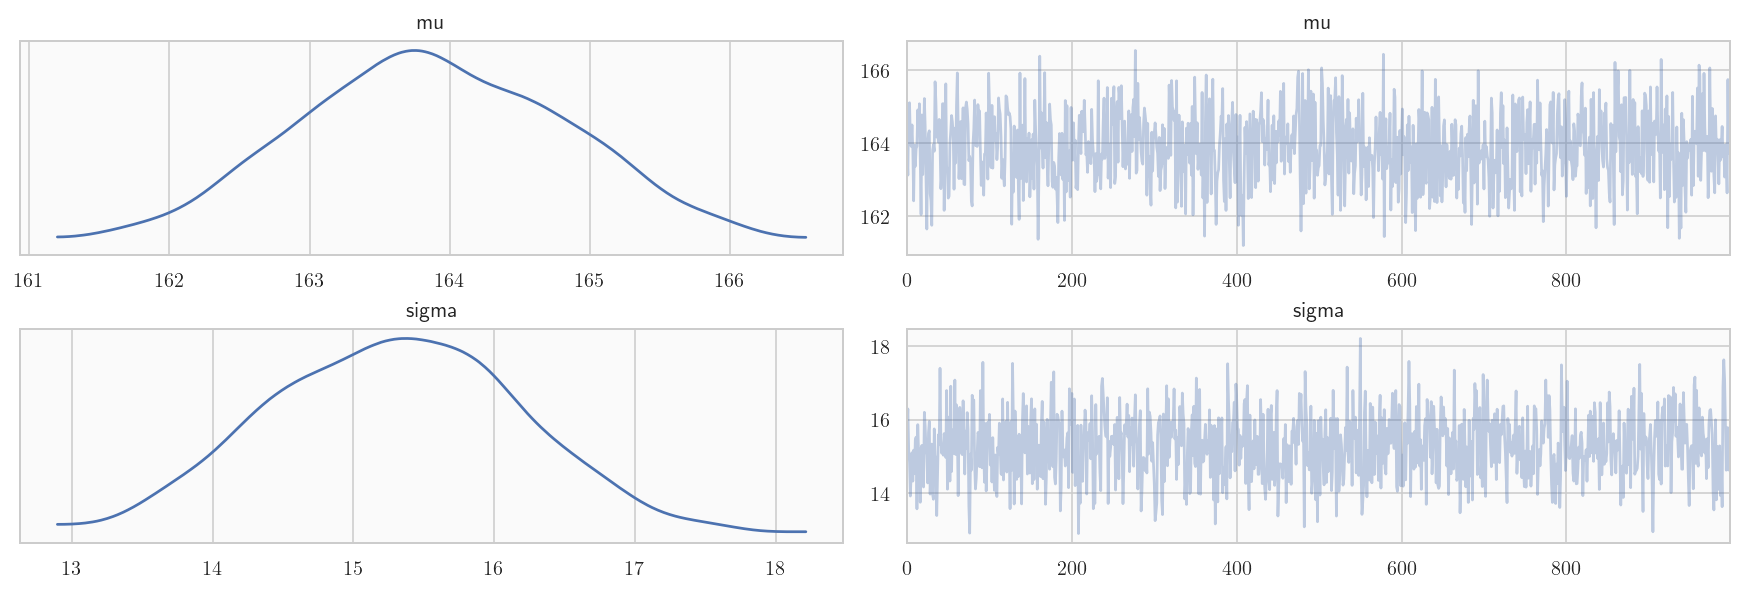

In [9]:
journal.plot_trace()
plt.show()

#### Plot posterior

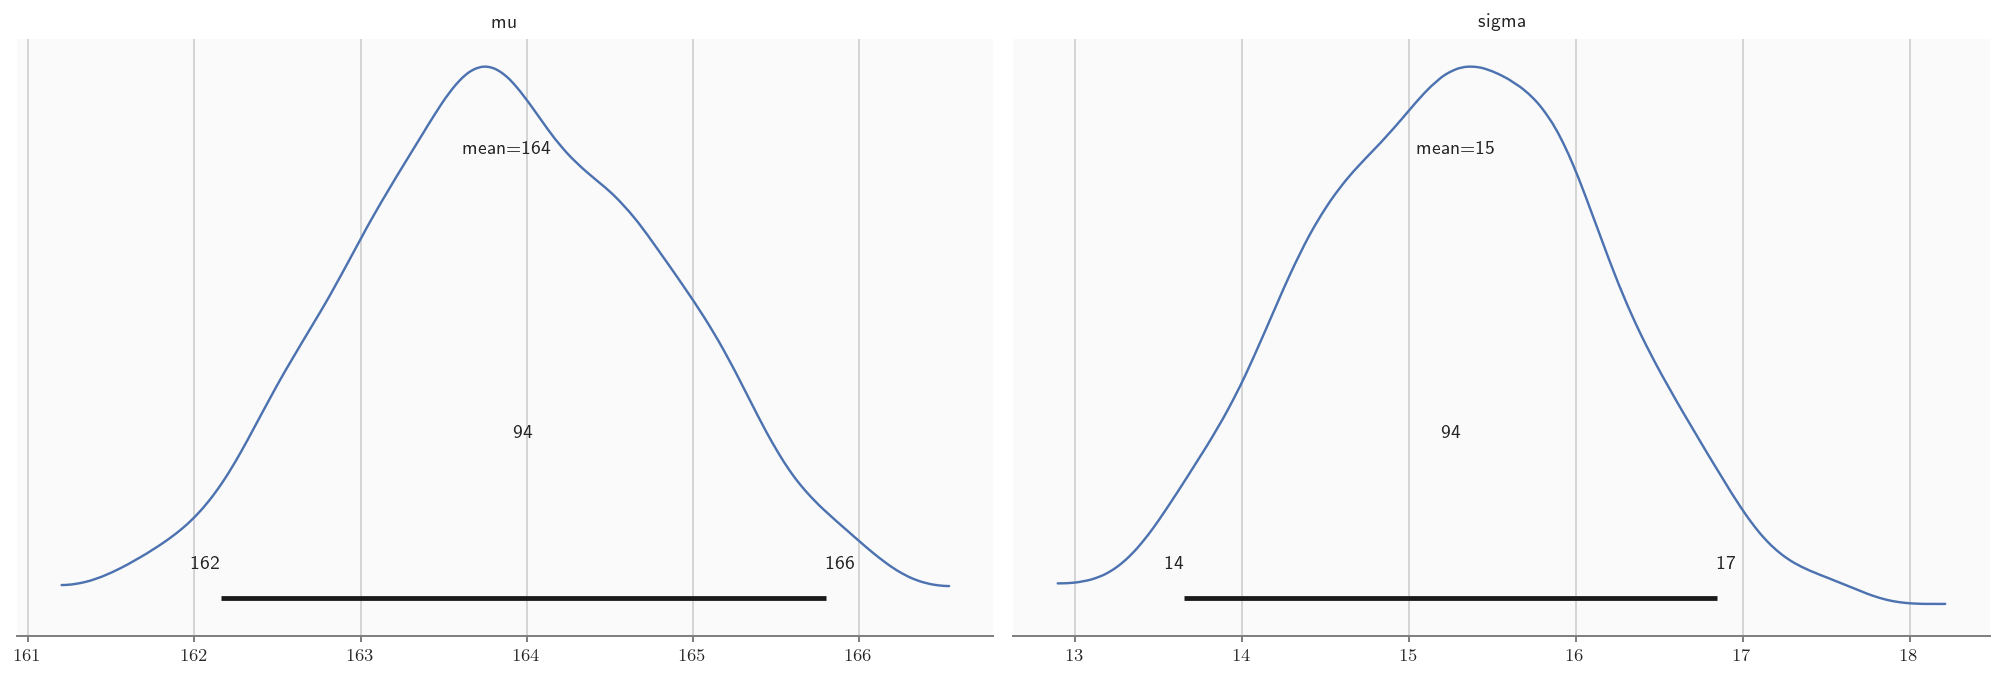

In [10]:
journal.plot_posterior()
plt.show()

#### With stricter acceptance threshold

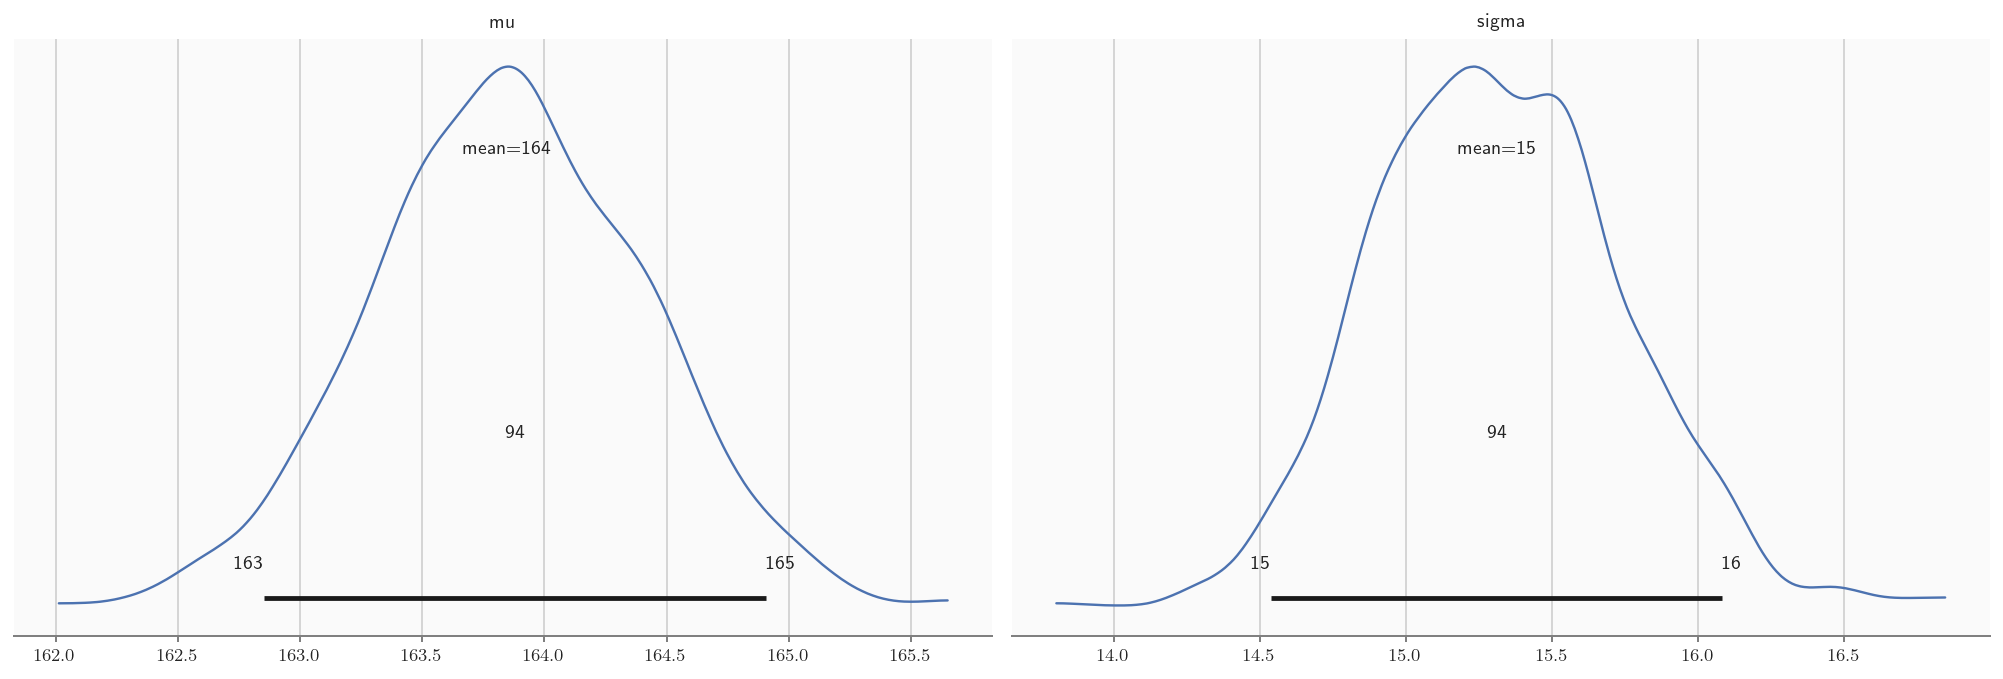

In [11]:
# inference config
n_samples = 1000
epsilon = 0.3

# run inference
journal = sampler.sample(n_samples,
                         epsilon=epsilon,
                         n_jobs=-1,
                         log=False
                         )

journal.plot_posterior()
plt.show()

#### With more informative priors

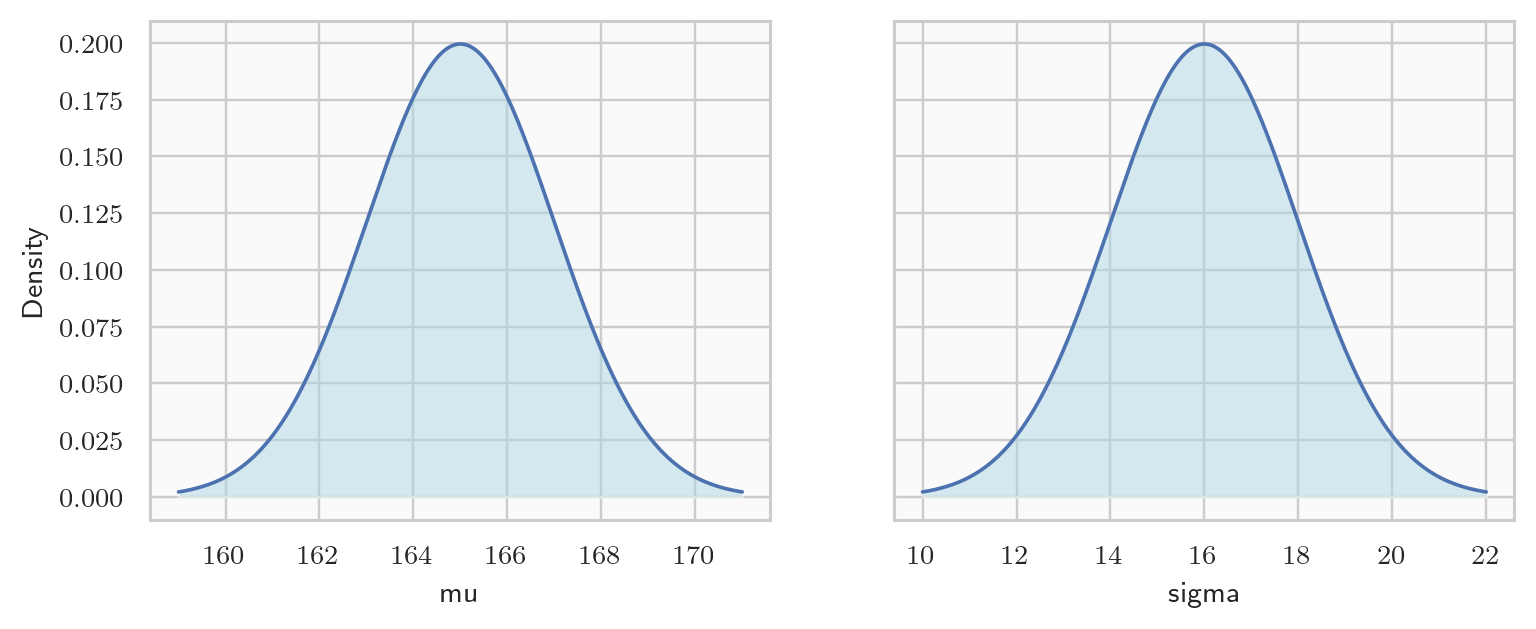

In [12]:
mu = pylfi.Prior('norm', loc=165, scale=2, name='mu')
sigma = pylfi.Prior('norm', loc=16, scale=2, name='sigma')
priors = [mu, sigma]

# Plot priors
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=110, sharey=True)

x = np.linspace(159, 171, 1000)
mu.plot_prior(x, ax=axes[0])

x = np.linspace(10, 22, 1000)
sigma.plot_prior(x, ax=axes[1])
axes[1].set_ylabel("")

plt.show()

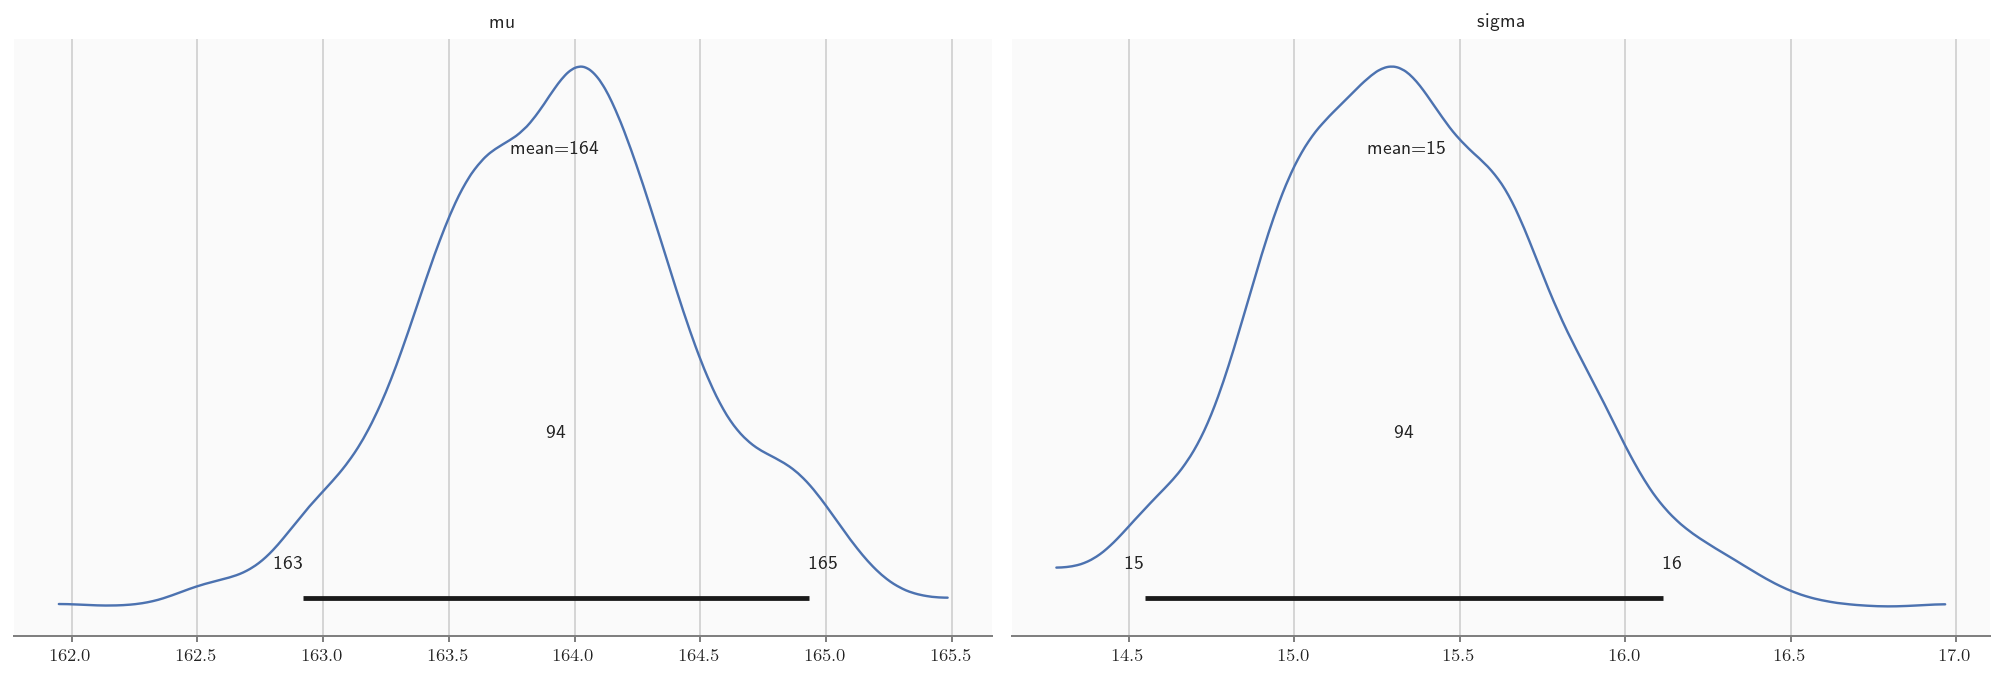

In [13]:
# initialize sampler
sampler = pylfi.RejABC(obs_data,
                       gaussian_model,
                       summary_calculator,
                       priors,
                       distance_metric='l2',
                       seed=42
                      )

# inference config
n_samples = 1000
epsilon = 0.3

# run inference
journal = sampler.sample(n_samples,
                         epsilon=epsilon,
                         n_jobs=-1,
                         log=False
                         )

journal.plot_posterior()
plt.show()

#### With increased number of posterior samples

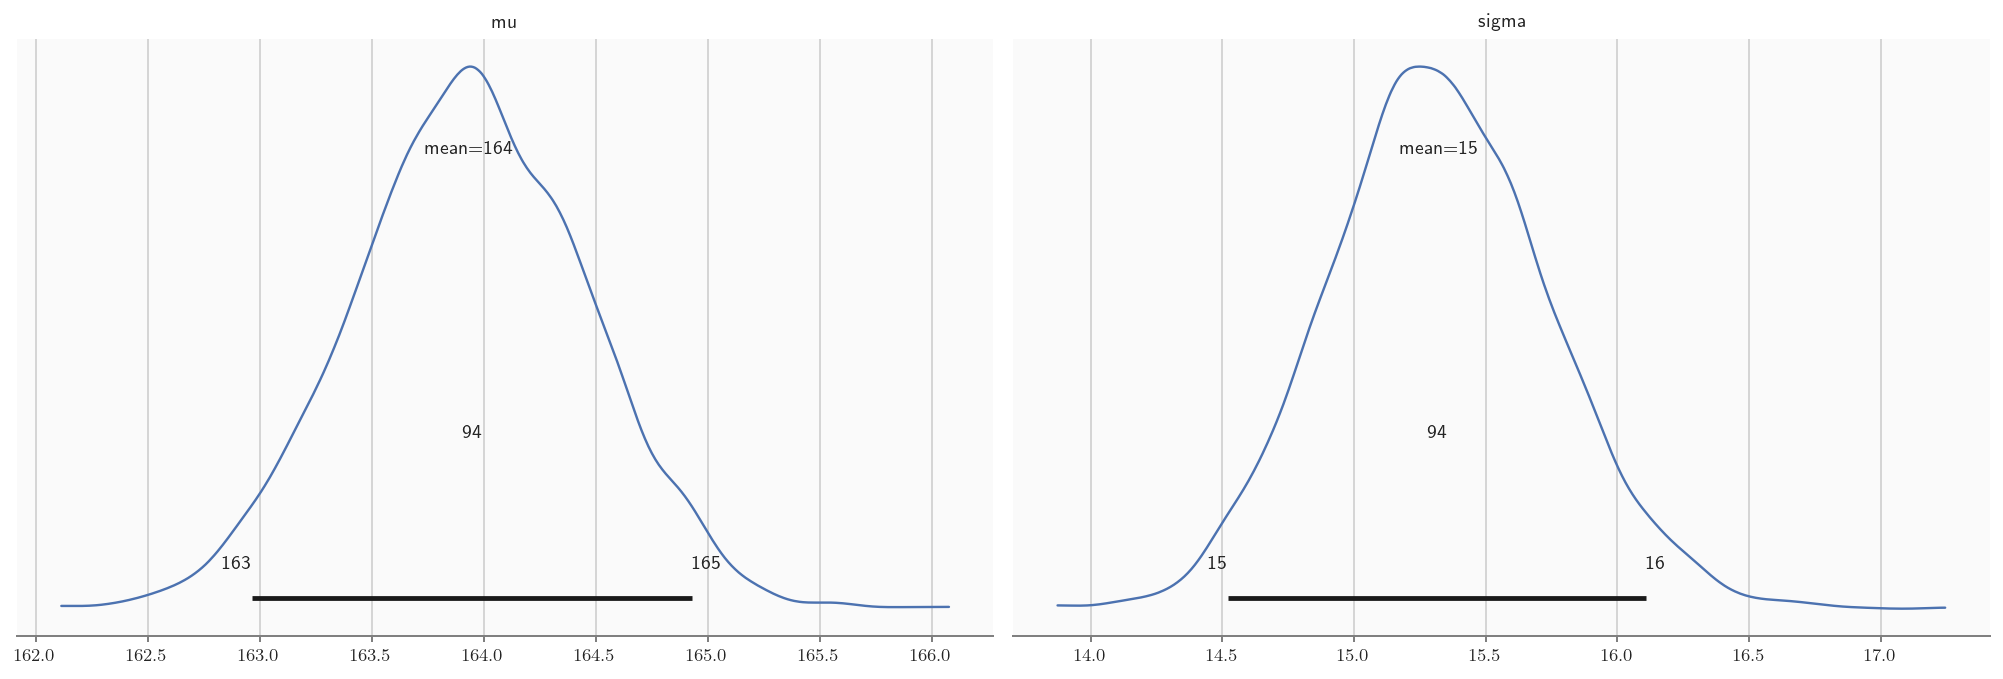

In [14]:
# inference config
n_samples = 5000
epsilon = 0.3

# run inference
journal = sampler.sample(n_samples,
                         epsilon=epsilon,
                         n_jobs=-1,
                         log=False
                         )

journal.plot_posterior()
plt.show()

### Automatic threshold selection

* Determining the threshold parameter $\epsilon$ can be quite finicky.
    * Requires knowledge about which distances we can expect between simulated and observed summary statistics.
   
   
* We can use the $p$-quantile as a criterion for automatic acceptance threshold selection


* We define the threshold as the $p$-quantile of the distances from $n_\mathrm{tune}$ samples in a pilot study.


* `pyLFI` has procedures for this. We only need to provide the $p$-quantile instead of $\epsilon$:

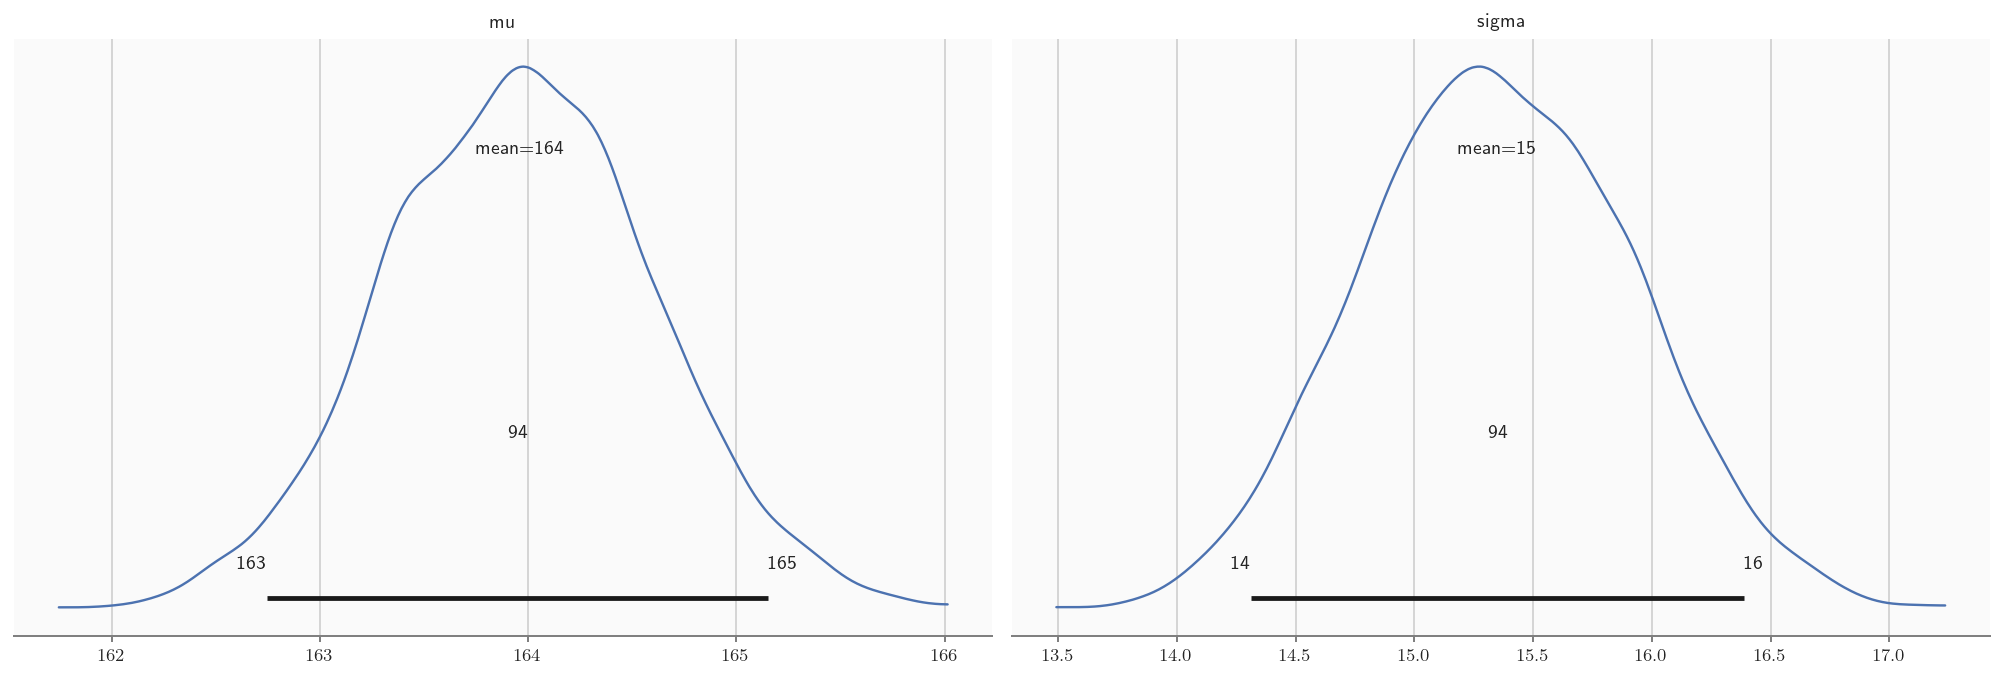

In [15]:
# inference config
n_samples = 5000
quantile = 0.07
n_tune = 500

# run inference
journal = sampler.sample(n_samples,
                         quantile=quantile,
                         n_jobs=-1,
                         n_tune=n_tune,
                         log=False
                         )

journal.plot_posterior()
plt.show()

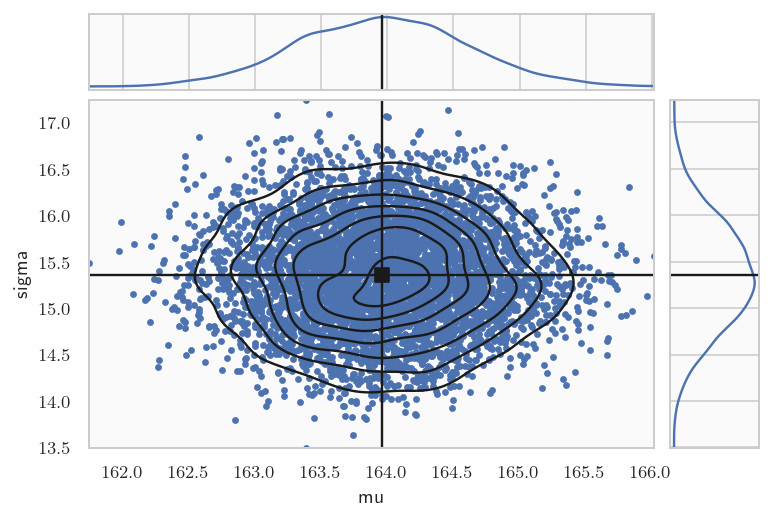

In [16]:
journal.plot_pair(var_names=["mu", "sigma"], figsize=(6, 4))
plt.show()

## <font color=darkcyan> The Hodgkin-Huxley Simulator </font>

In [17]:
import neuromodels as nm


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Simulation

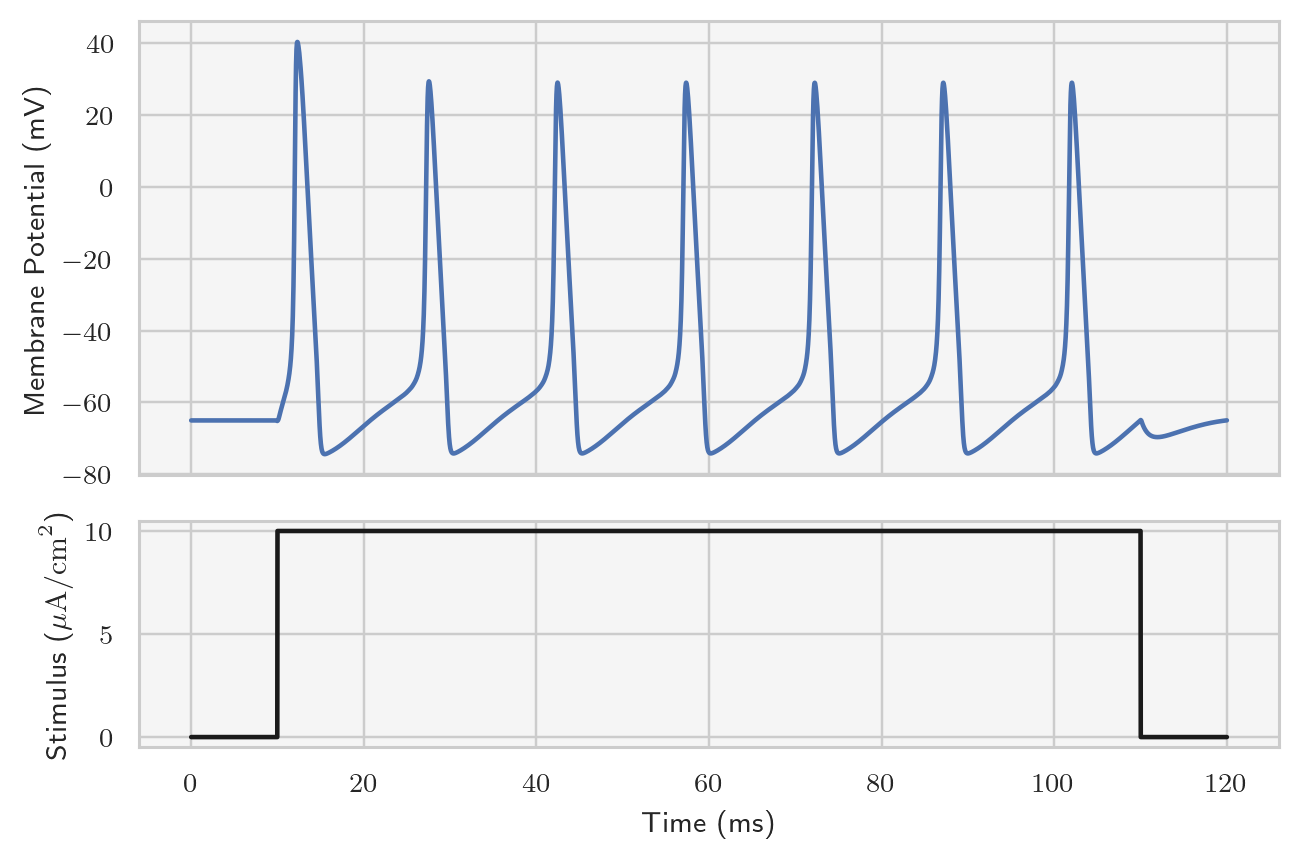

In [18]:
# Simulation parameters 
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]

# Define input stimulus
# Can be defined as a constant, a callable with signature '(t)' or an array of values
class ConstantStimulus:
    def __init__(self, I_amp, t_stim_on, t_stim_off):
        self.I_amp = I_amp
        self.t_stim_on = t_stim_on
        self.t_stim_off = t_stim_off

    def __call__(self, t):
        return self.I_amp if self.t_stim_on <= t <= self.t_stim_off else 0

stimulus = ConstantStimulus(I_amp, t_stim_on, t_stim_off)

# Create instance of simulator. 
# Model parameters must be passed to constructor
hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# Instance is callable and returns simulation results. 
# The conductance parameters can be passed as parameters
V, t = hh(gbar_K=36., gbar_Na=120.)

# Plot simulation
hh.plot_voltage_trace(with_stim=True, figsize=(6, 4), dpi=110)
plt.show()

### Spike Statistics 

`NeuroModels` has procedures for computing several spike statistics: 

1. __Spike rate:__ The action potential firing rate, which is the number of
    action potentials divided by stimulus duration.
2. __Latency to first spike:__ The time between stimulus onset and first spike occurrence.
3. __Average AP overshoot__: Average action potential peak voltage. Average AP overshoot is calculated by averaging the absolute peak voltage values of all action potentials (spikes).
4. __Average AHP depth:__ The average depth of after hyperpolarization (AHP), i.e., average minimum voltage between action potentials. The average AHP depth is obtained by averaging the minimum voltage between two consecutive APs.
5. __Average AP width:__ The average action potential width. The average AP width is calculated by averaging the width of every AP at the midpoint between its onset and its peak.
6. __Accommodation index:__ Accommodation index, which is the normalized average difference in length of two consecutive interspike intervals (ISIs).

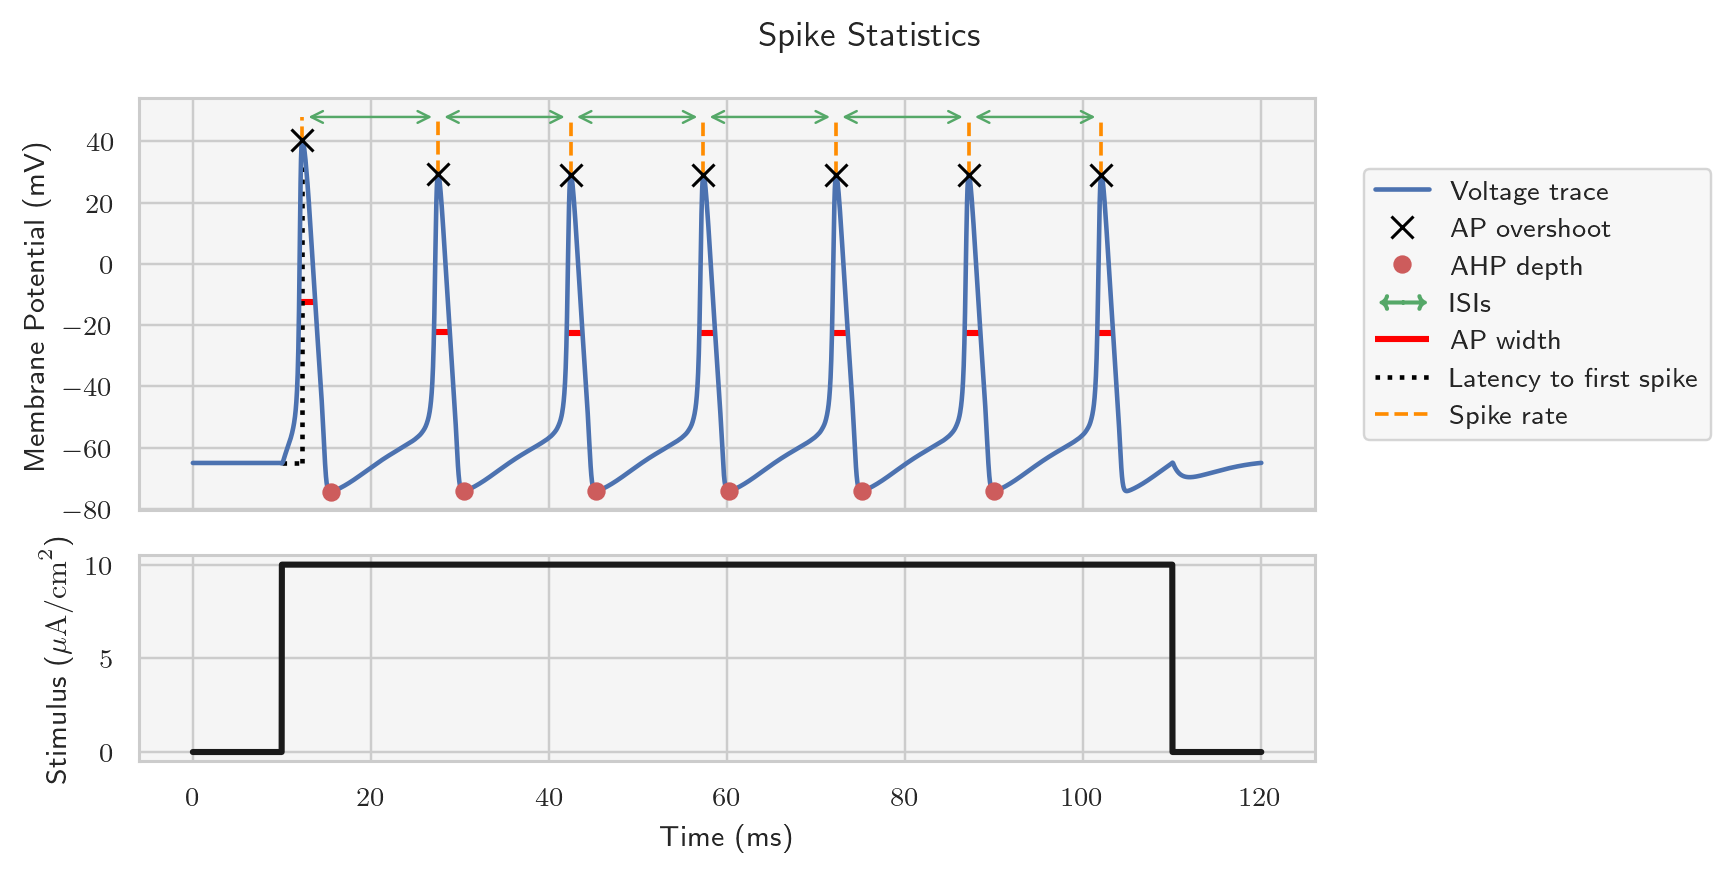

In [19]:
hh.plot_spike_statistics(t_stim_on, t_stim_off, figsize=(8, 4), dpi=110)
plt.show()

In [20]:
s_stats = ["n_spikes",
           "spike_rate",
           "latency_to_first_spike",
           "average_AP_overshoot",
           "average_AHP_depth",
           "average_AP_width",
           "accommodation_index"]

# Create instance of spike statistics class
sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on, 
                               t_stim_off=t_stim_off, 
                               stats=s_stats
                              )

# Instance is callable and returns the summary statistics
# passed to the 'stats' keyword in the constructor. 
# The simulation results must be passed as parameters. 
sum_stats = sps(V, t)

print(f"Number of spikes: {sum_stats[0]}")
print(f"Spike rate: {sum_stats[1]:.4f} mHz")
print(f"Latency to first spike: {sum_stats[2]:.4f} ms")
print(f"Average AP overshoot: {sum_stats[3]:.4f} mV")
print(f"Average AHP depth: {sum_stats[4]:.4f} mV")
print(f"Average AP width: {sum_stats[5]:.4f} mV")
print(f"Accommodation index: {sum_stats[6]:.4f}")

Number of spikes: 7
Spike rate: 0.0700 mHz
Latency to first spike: 2.3000 ms
Average AP overshoot: 30.7316 mV
Average AHP depth: -63.6200 mV
Average AP width: 2.0501 mV
Accommodation index: 0.0000


## <font color=darkcyan> Parameter Inference with Rejection ABC </font>

### Simulator model 

In [21]:
class ConstantStimulus:
    def __init__(self, I_amp, t_stim_on, t_stim_off):
        self.I_amp = I_amp
        self.t_stim_on = t_stim_on
        self.t_stim_off = t_stim_off

    def __call__(self, t):
        return self.I_amp if self.t_stim_on <= t <= self.t_stim_off else 0
    
    
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]    
stimulus = ConstantStimulus(I_amp, t_stim_on, t_stim_off)

hh = nm.models.HodgkinHuxley(stimulus, T, dt)

### Summary statistics calculator

In [22]:
s_stats = ["spike_rate"]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on, 
                               t_stim_off=t_stim_off, 
                               stats=s_stats
                              )

### Observed data

In [23]:
gbar_K_true = 36 
gbar_Na_true = 120 
true_parameter_values = [gbar_K_true, gbar_Na_true]

V, t = hh(gbar_K=gbar_K_true, gbar_Na=gbar_Na_true)
obs_data = (V, t)

### Priors

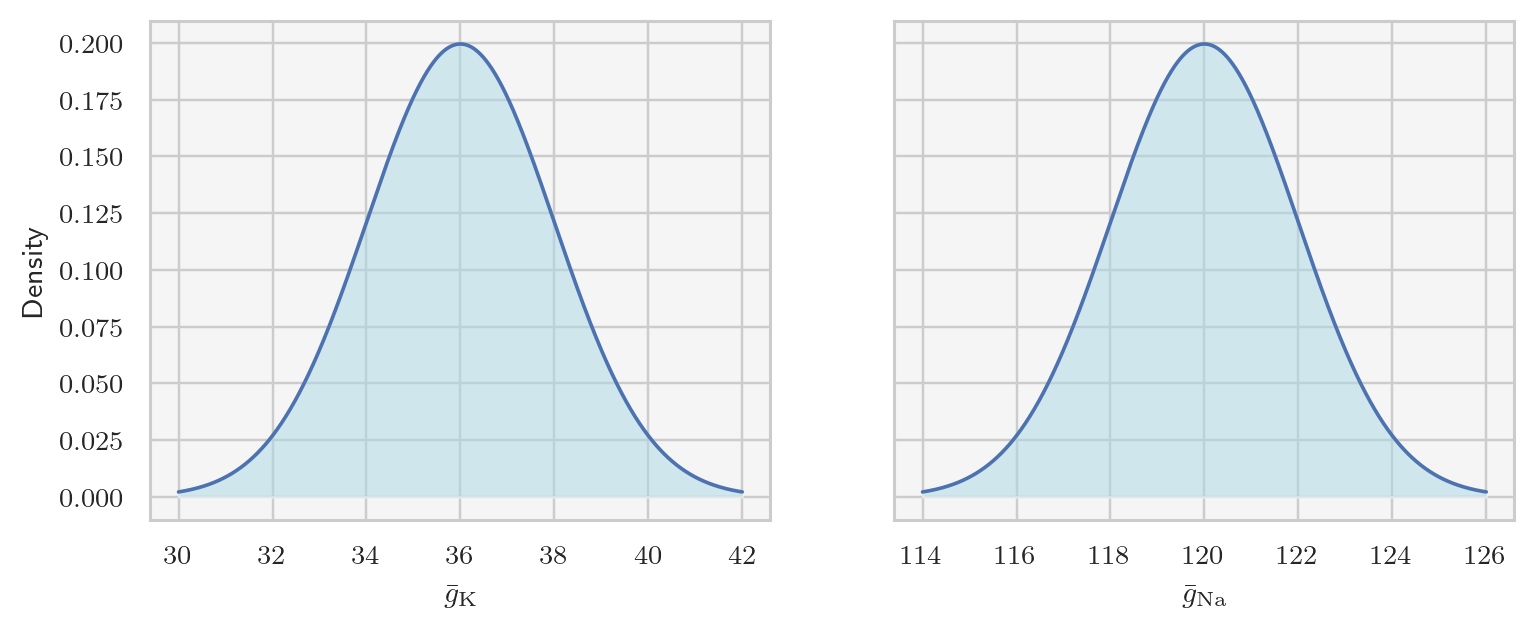

In [24]:
gbar_K = pylfi.Prior('norm', loc=36, scale=2, name='gbarK', tex=r"$\bar{g}_\mathrm{K}$")
gbar_Na = pylfi.Prior('norm', loc=120, scale=2, name='gbarNa', tex=r"$\bar{g}_\mathrm{Na}$")
priors = [gbar_K, gbar_Na]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=110, sharey=True)
# Plot priors
x = np.linspace(30, 42, 1000)
gbar_K.plot_prior(x, ax=axes[0])

x = np.linspace(114, 126, 1000)
gbar_Na.plot_prior(x, ax=axes[1])
axes[1].set_ylabel("")

plt.show()

### Rejection ABC sampler

In [25]:
# initialize sampler
sampler = pylfi.RejABC(obs_data, 
                       hh,
                       sps, 
                       priors, 
                       distance_metric='l2',
                       seed=42
                      )

# inference config
n_samples = 500
quantile = 0.7
n_tune = 500

# run inference
journal = sampler.sample(n_samples,
                         quantile=quantile,
                         n_jobs=-1,
                         n_tune=n_tune,
                         log=False
                         )


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find

In [26]:
idata = journal.idata
idata

Inference data with groups:
	> posterior

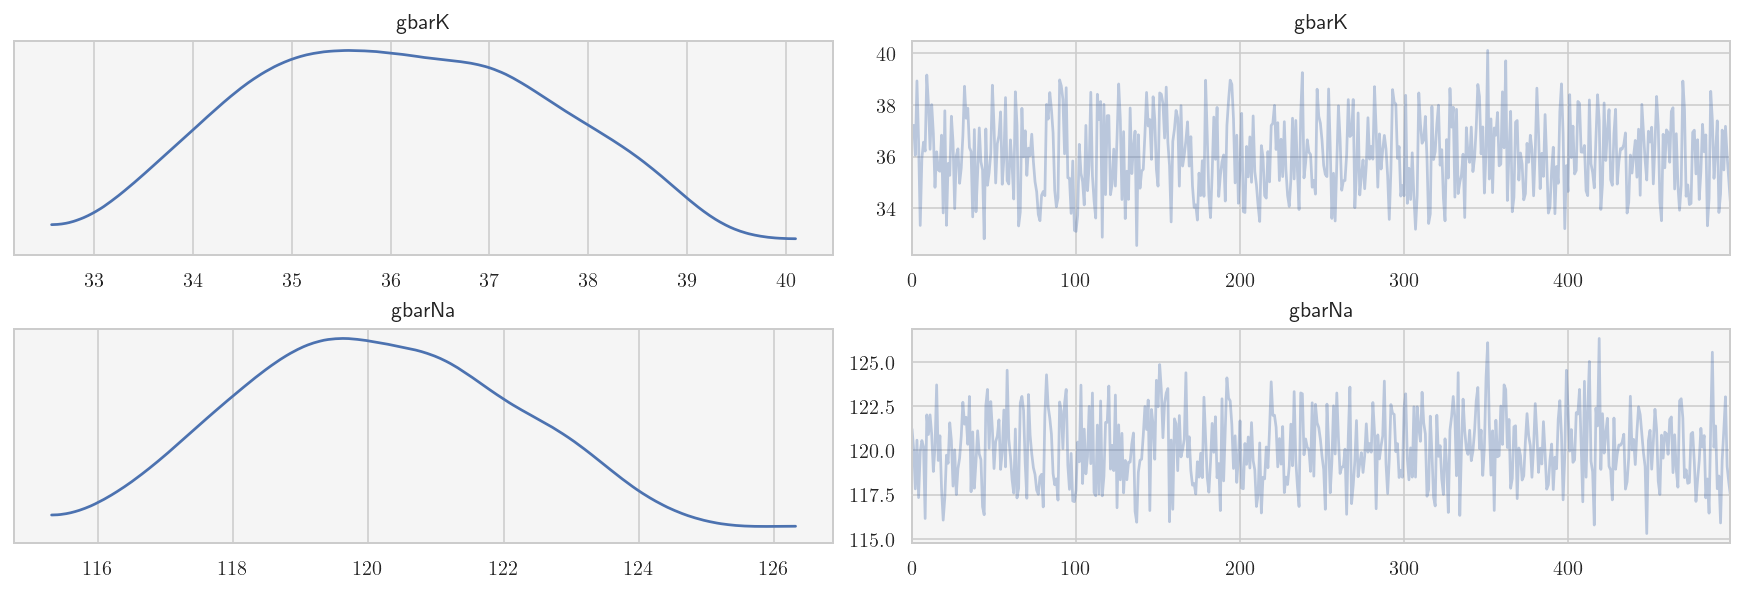

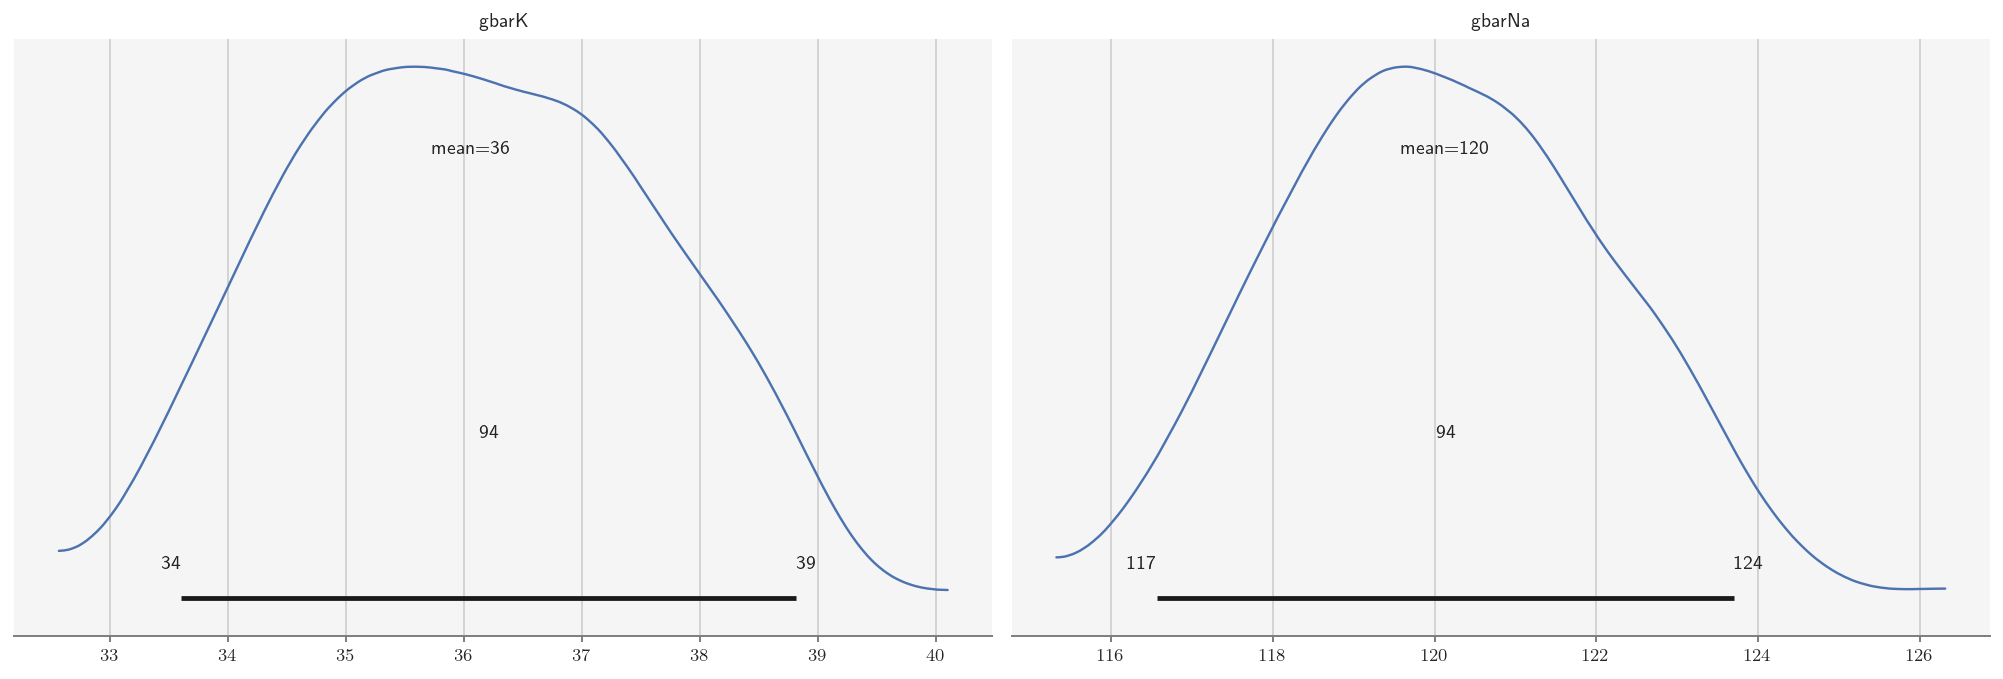

In [27]:
journal.plot_trace()
journal.plot_posterior()
plt.show()

#### With other summary statistics

In [28]:
s_stats = ["latency_to_first_spike", "average_AP_overshoot"]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on, 
                               t_stim_off=t_stim_off, 
                               stats=s_stats
                              )

# initialize sampler
sampler = pylfi.RejABC(obs_data, 
                       hh,
                       sps, 
                       priors, 
                       distance_metric='l2',
                       seed=42
                      )

# inference config
n_samples = 500
quantile = 0.5
n_tune = 500

# run inference
journal = sampler.sample(n_samples,
                         quantile=quantile,
                         n_jobs=-1,
                         n_tune=n_tune,
                         log=False
                         )

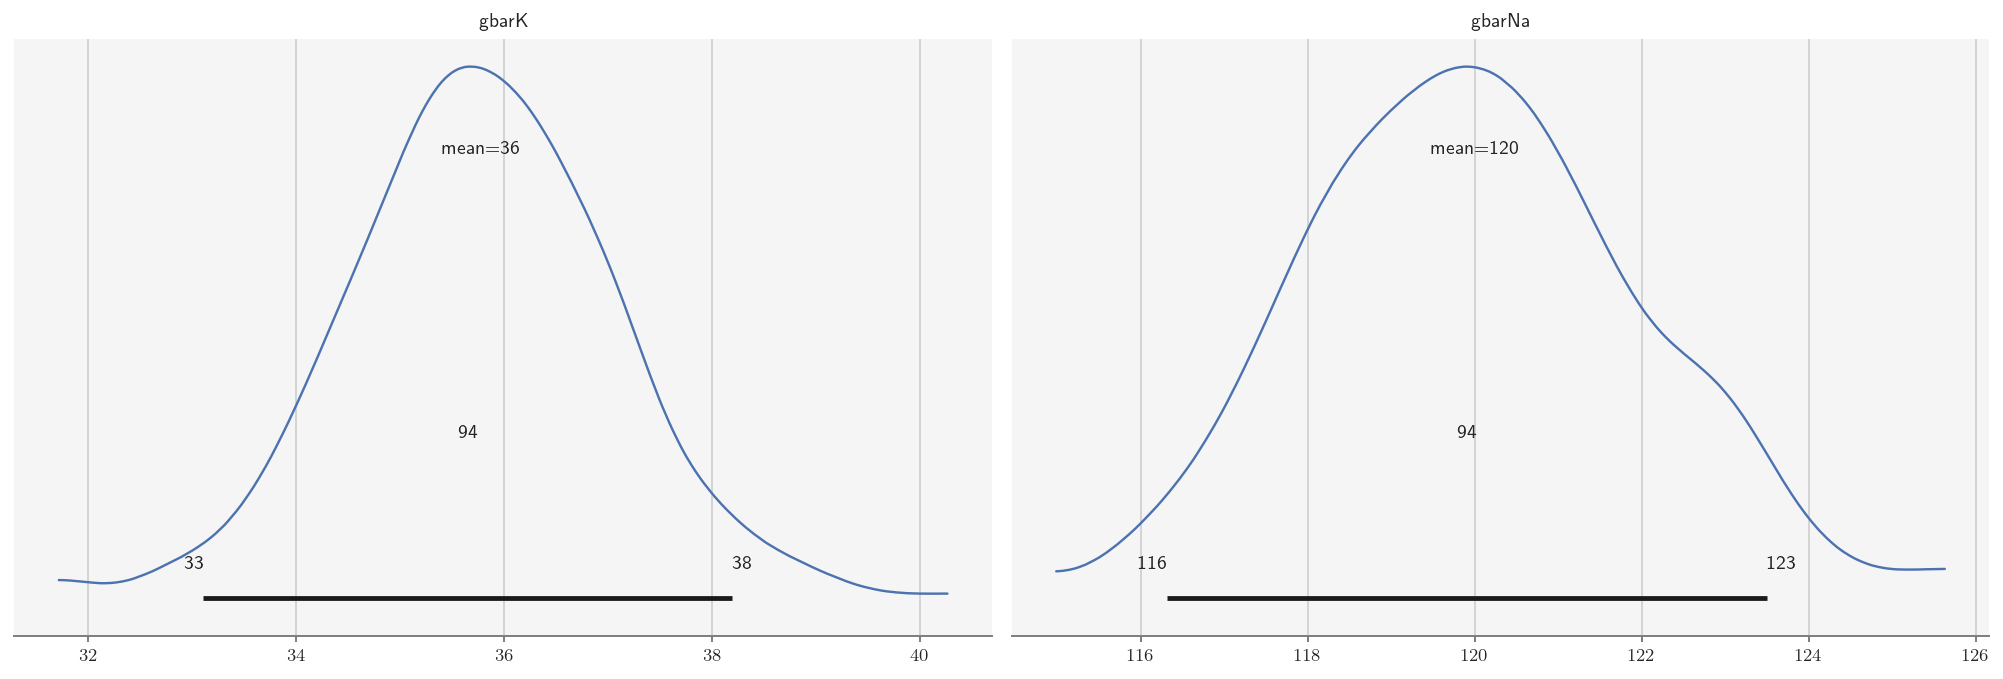

In [29]:
journal.plot_posterior()
plt.show()

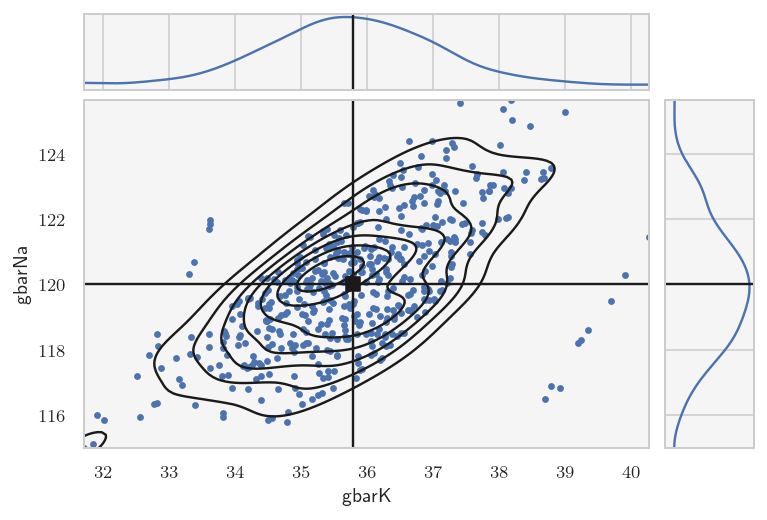

In [41]:
journal.plot_pair(var_names=["gbarK", "gbarNa"], figsize=(6, 4))
plt.show()

### Spike statistics vs. model parameters

In [30]:
# model parameters
N = 100
gbar_K_fixed = 36
gbar_Na_fixed = 120 

gbar_Ks = np.linspace(26, 46, N)
gbar_Nas = np.linspace(110, 130, N)

# statistics calculator 
s_stats = ["spike_rate",
           "latency_to_first_spike",
           "average_AP_overshoot",
           "average_AHP_depth",
           "average_AP_width",
           "accommodation_index"]

sps = nm.statistics.SpikeStats(t_stim_on, t_stim_off, stats=s_stats)

In [31]:
stats_data_gbar_K = {stat: [] for stat in s_stats}

for gbar_K in tqdm(gbar_Ks):
    V, t = hh(gbar_K, gbar_Na_fixed)
    sum_stats = sps(V, t)
    for i, key in enumerate(stats_data_gbar_K):
        stats_data_gbar_K[key].append(sum_stats[i])

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
stats_data_gbar_Na = {stat: [] for stat in s_stats}
for gbar_Na in tqdm(gbar_Nas):
    V, t = hh(gbar_K_fixed, gbar_Na)
    sum_stats = sps(V, t)
    for i, key in enumerate(stats_data_gbar_Na):
        stats_data_gbar_Na[key].append(sum_stats[i])

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
df_gbar_K = pd.DataFrame.from_dict(stats_data_gbar_K)
df_gbar_K["gbar_K"] = gbar_Ks
df_gbar_K.head()

,spike_rate,latency_to_first_spike,average_AP_overshoot,average_AHP_depth,average_AP_width,accommodation_index,gbar_K
0,0.08,2.275,33.959973,-64.266192,2.152194,-1.632387e-04,26.000000
1,0.08,2.300,33.929557,-64.285613,2.151207,6.938894e-17,26.202020
2,0.08,2.225,33.883757,-64.304214,2.161738,-1.622850e-04,26.404040
3,0.08,2.200,33.854710,-64.322978,2.155499,1.619695e-04,26.606061
4,0.08,2.275,33.809596,-64.340968,2.157929,0.000000e+00,26.808081


In [34]:
df_gbar_Na = pd.DataFrame.from_dict(stats_data_gbar_Na)
df_gbar_Na["gbar_Na"] = gbar_Nas
df_gbar_Na.head()

,spike_rate,latency_to_first_spike,average_AP_overshoot,average_AHP_depth,average_AP_width,accommodation_index,gbar_Na
0,0.06,2.3,26.403282,-61.753240,1.665784,-1.074951e-16,110.000000
1,0.07,2.3,26.005419,-63.512657,1.897401,7.581501e-04,110.202020
2,0.07,2.3,26.274960,-63.516072,1.892478,-2.170573e-17,110.404040
3,0.07,2.3,26.498719,-63.519354,1.912094,-4.358493e-17,110.606061
4,0.07,2.3,26.738715,-63.522654,1.936848,-4.379308e-17,110.808081


#### Plot summary statistics versus model parameters. 

Each plot is generated by varying one parameter while the other is held fixed.

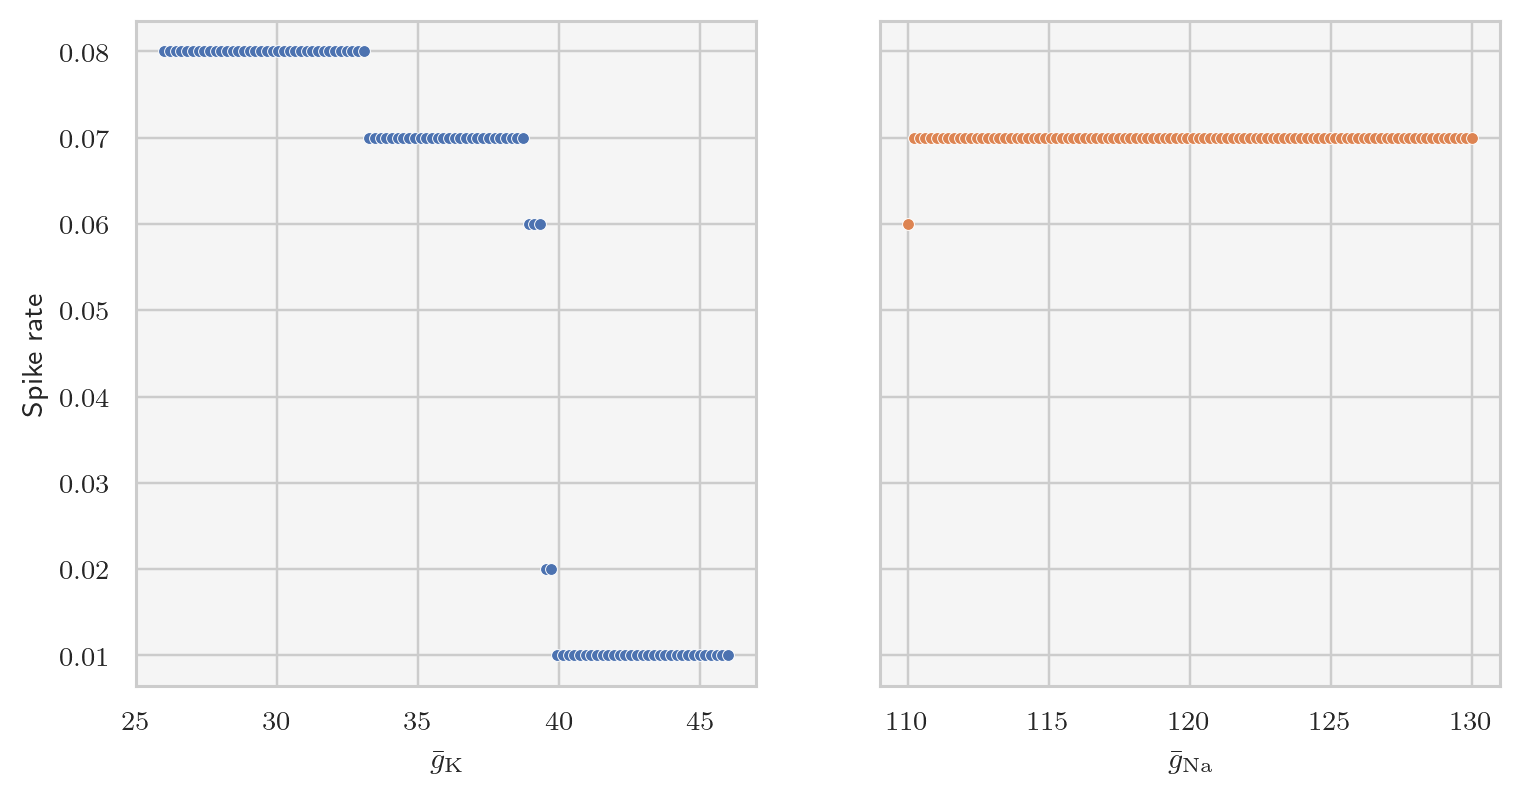

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=110, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="spike_rate",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, 
                ax=axes[1], 
                x="gbar_Na",
                y="spike_rate", 
                color="C1", 
                s=15
               )
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$",
            ylabel=r"Spike rate")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$")
plt.show()

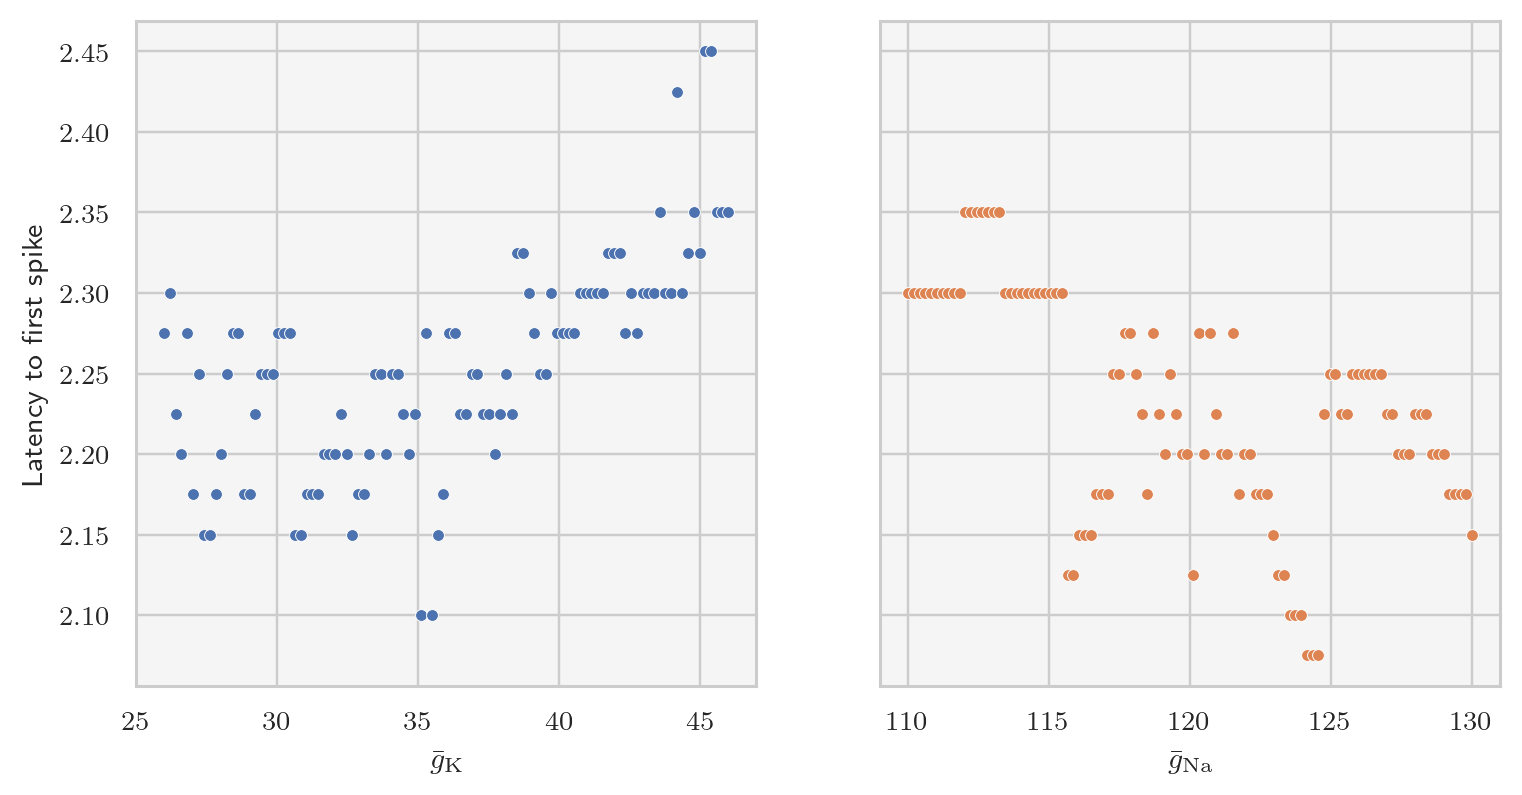

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=110, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="latency_to_first_spike",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, 
                ax=axes[1], 
                x="gbar_Na",
                y="latency_to_first_spike", 
                color="C1", 
                s=15
               )
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$",
            ylabel=r"Latency to first spike")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$")
plt.show()

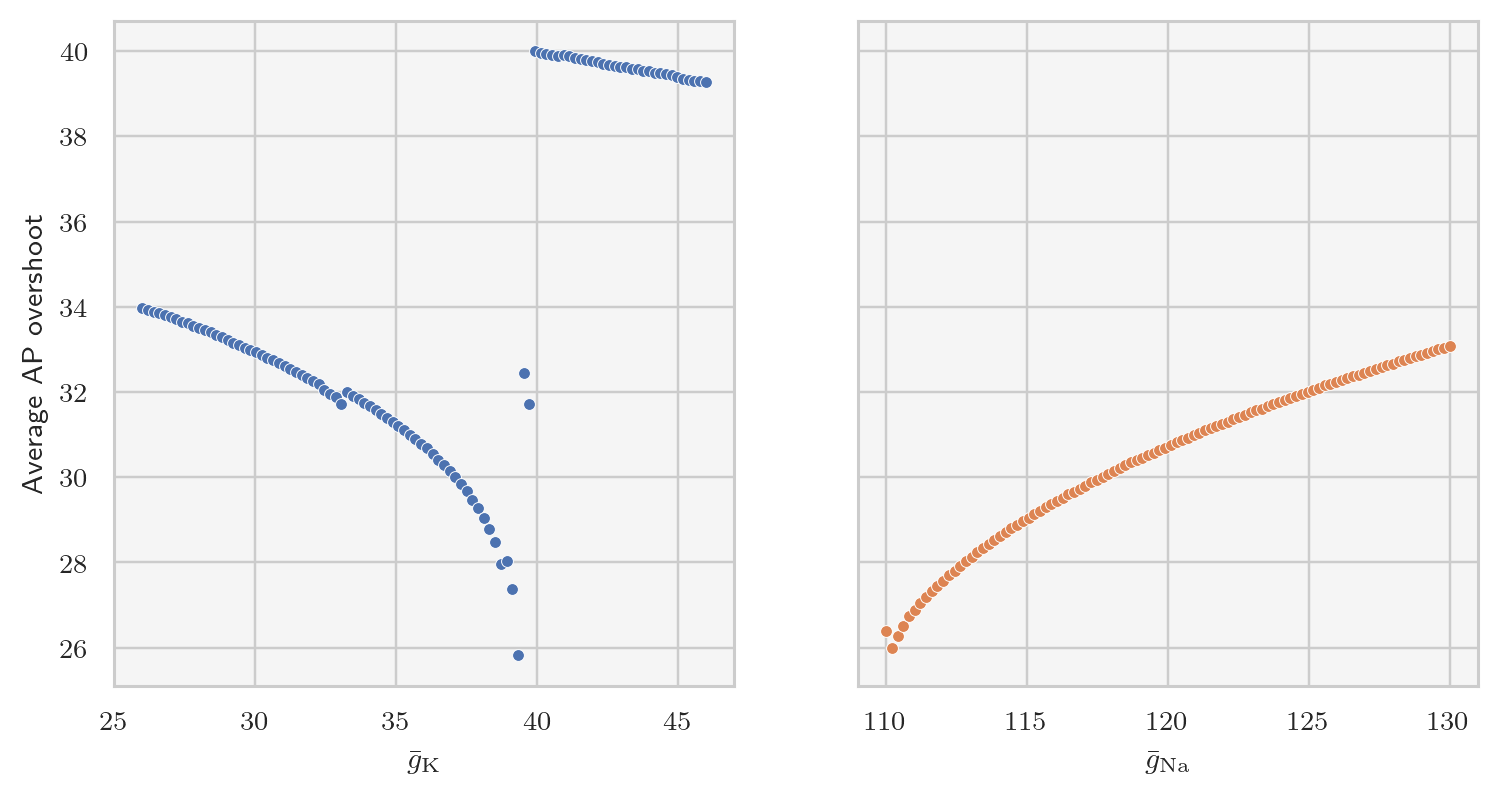

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=110, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="average_AP_overshoot",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, 
                ax=axes[1], 
                x="gbar_Na",
                y="average_AP_overshoot", 
                color="C1", 
                s=15
               )
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$",
            ylabel=r"Average AP overshoot")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$")
plt.show()

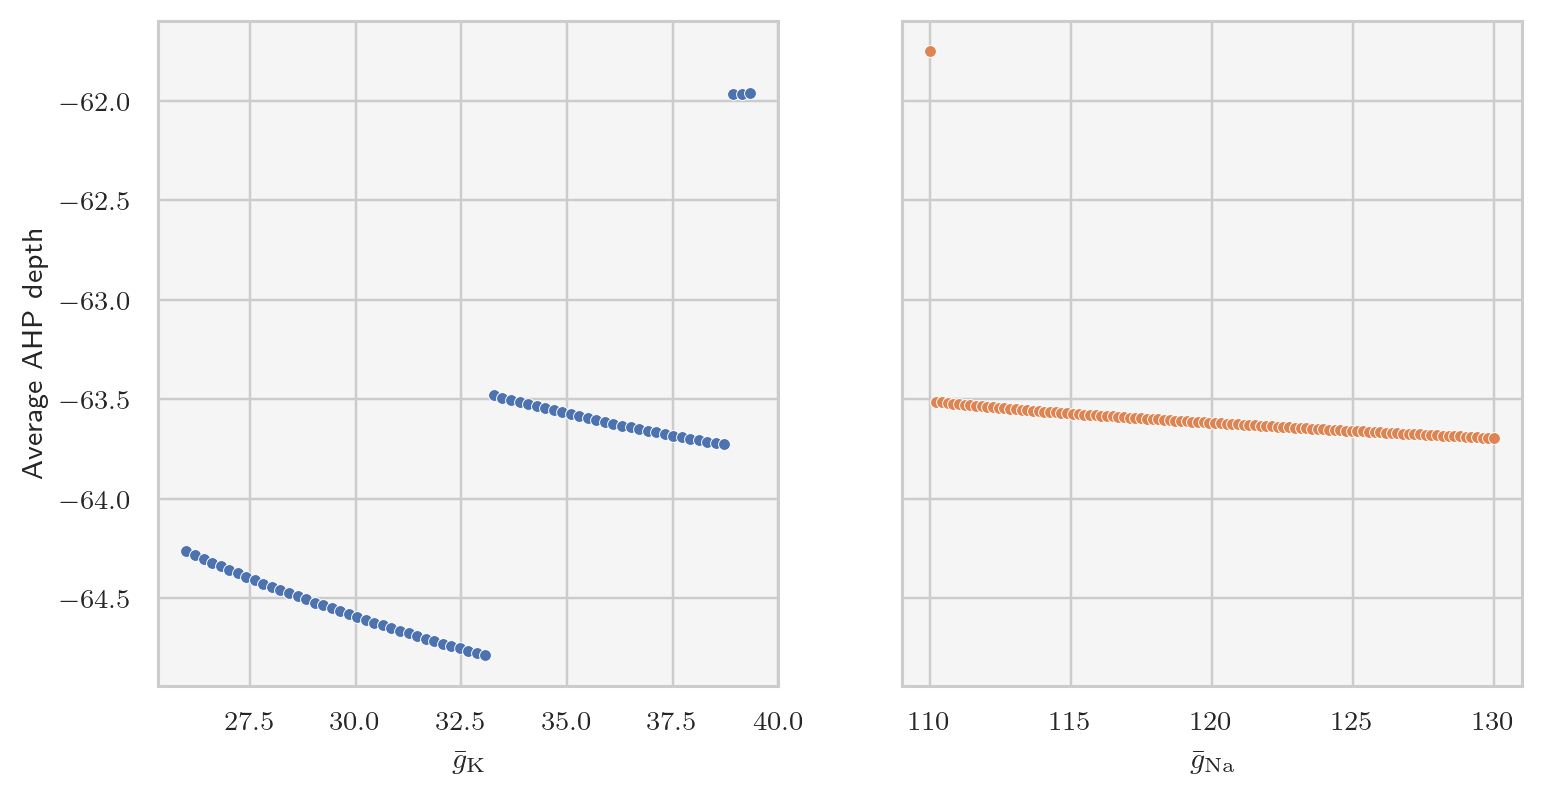

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=110, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="average_AHP_depth",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, 
                ax=axes[1], 
                x="gbar_Na",
                y="average_AHP_depth", 
                color="C1", 
                s=15
               )
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$",
            ylabel=r"Average AHP depth")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$")
plt.show()

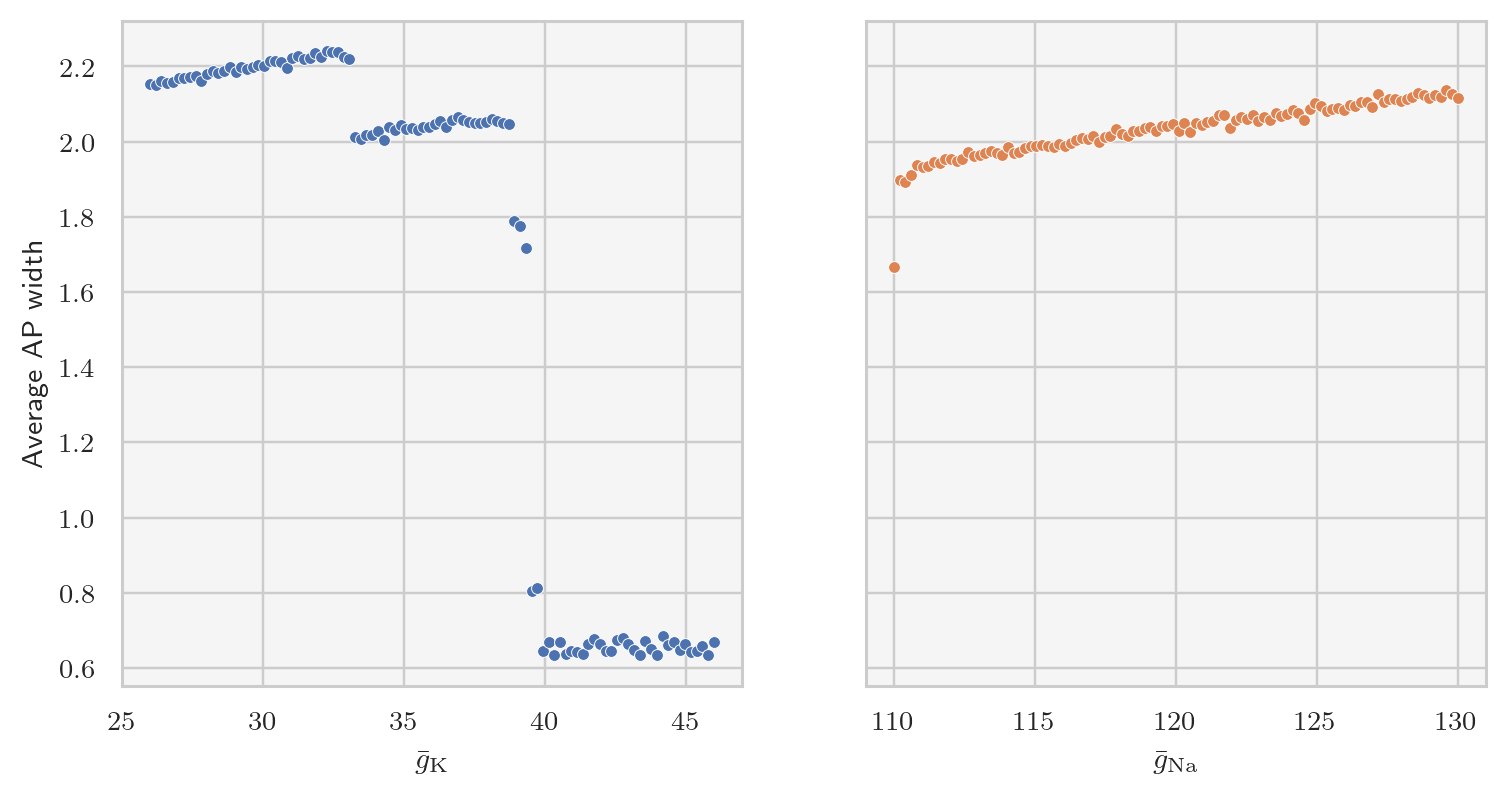

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=110, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="average_AP_width",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, 
                ax=axes[1], 
                x="gbar_Na",
                y="average_AP_width", 
                color="C1", 
                s=15
               )
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$",
            ylabel=r"Average AP width")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$")
plt.show()

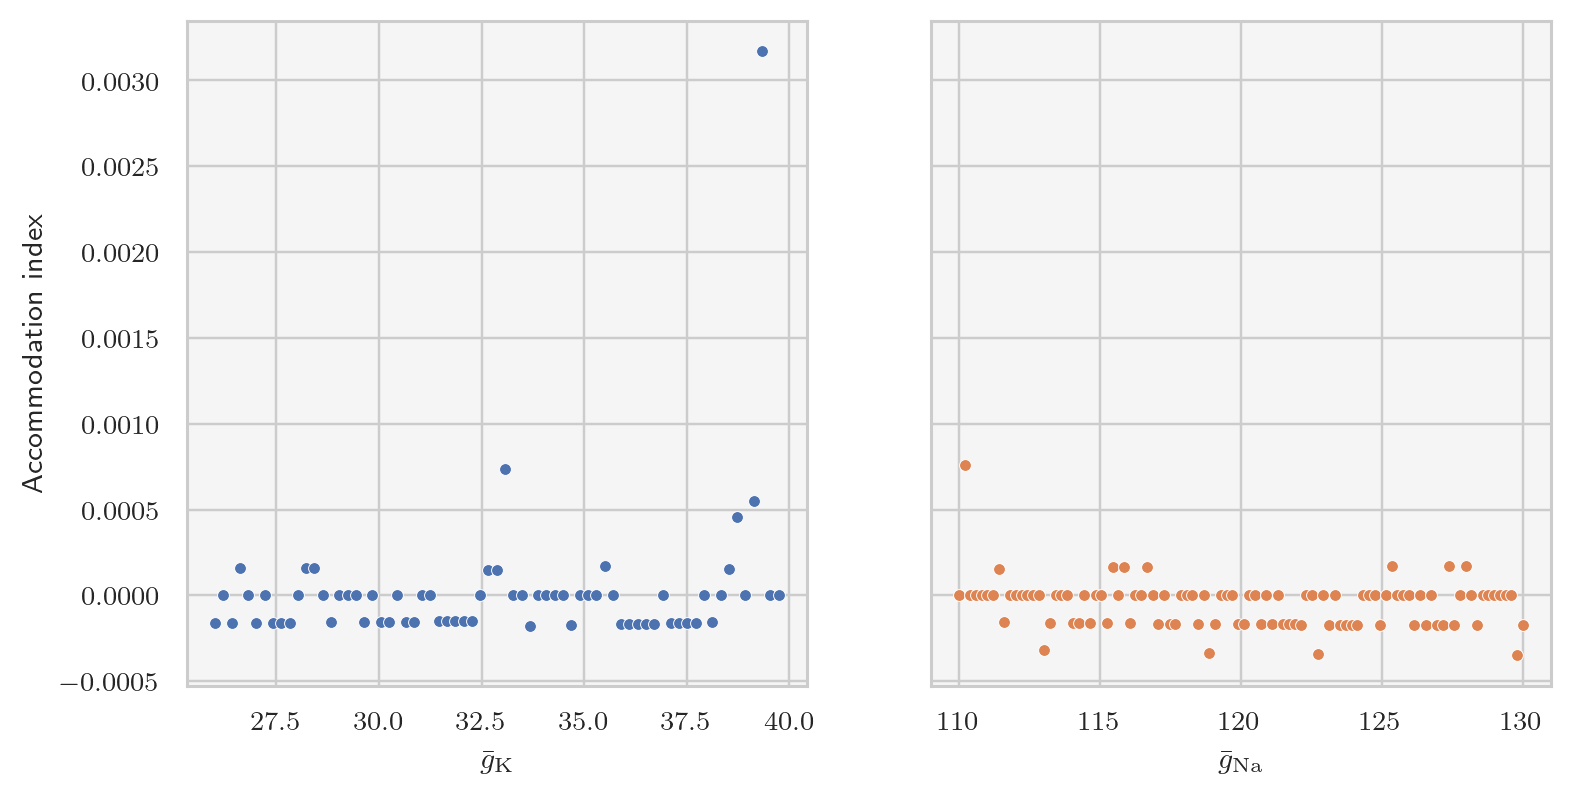

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=110, sharey=True)
sns.scatterplot(data=df_gbar_K, 
                ax=axes[0], 
                x="gbar_K", 
                y="accommodation_index",
                color="C0", 
                s=15
               )
sns.scatterplot(data=df_gbar_Na, 
                ax=axes[1], 
                x="gbar_Na",
                y="accommodation_index", 
                color="C1", 
                s=15
               )
axes[0].set(xlabel=r"$\bar{g}_\mathrm{K}$",
            ylabel=r"Accommodation index")
axes[1].set_xlabel(r"$\bar{g}_\mathrm{Na}$")
plt.show()

## <font color=darkcyan> Concluding Remarks </font>

* The data generation step in ABC algorithms tends to be expensive. 


* In <font color=darkred>Rejection ABC</font>, proposal parameters are sampled from the prior.
    * <font color=darkred>Pro:</font> Efficient to draw random samples from prior
    * <font color=darkred>Con:</font> Efficiency of overall procedure is determined by whether the prior is chosen such that it is of a similar shape and location to the desired posterior
    

* The acceptance rate will be low if the approximate posterior is significantly narrower than the prior, as is often the case, and the rejection ABC algorithm will hence be computationally inefficient as more of the expensive data generation is necessary. 


* In this case, we might choose to develop a recursive strategy where the quality of previous candidates in our sampling algorithm can be used to guide the candidate generation process. 


* Basing proposal samples off of previous states is precisely the strategy behind conventional Markov chain Monte Carlo (MCMC) methods.


* The most popular MCMC sampler is the Metropolis-Hastings algorithm.


* MCMC ABC with the Metropolis-Hastings sampler is also implemented in `pyLFI`. 


* But that is a story for another time.